# 🚀 Evaluación de Modelos ONNX en Hardware Embebido

**Objetivo:** Evaluar modelos ONNX para navegación autónoma en Raspberry Pi 5 y Jetson Orin.

**Plataformas soportadas:**
- 🍓 Raspberry Pi 5 (ARM Cortex-A76, 8GB RAM)
- 🤖 NVIDIA Jetson Orin (CUDA-enabled)
- 💻 Desktop/Laptop (para comparación)

**Métricas evaluadas:**
- ⏱️ Latencia de inferencia (ms)
- 📊 Throughput (FPS)
- 💾 Uso de memoria
- 🎯 Precisión (MSE, RMSE, MAE, R²)
- 📏 Tamaño de modelo
- 🔄 Comparación PyTorch vs ONNX

---

## 📦 1. Imports y Detección de Hardware

In [1]:
import onnxruntime as ort
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')  # Backend sin GUI para hardware embebido
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import time
import psutil
import platform
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')
import torch
import gc

print("🔍 DETECCIÓN DE HARDWARE")
print("="*70)

# Información del sistema
print(f"\n💻 Sistema: {platform.system()} {platform.release()}")
print(f"🏗️  Arquitectura: {platform.machine()}")# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# ============================================================================
# CONFIGURACIÓN DE MEMORIA
# ============================================================================

# Tamaño de batch para evaluación (reducir si hay problemas de memoria)
EVAL_BATCH_SIZE = 32  # Procesar 32 muestras a la vez
MAX_SAMPLES = None  # None = usar todo el dataset, o un número como 1000 para pruebas rápidas


print("="*70)
print(f"🔧 Procesador: {platform.processor()}")
print(f"💾 RAM Total: {psutil.virtual_memory().total / (1024**3):.2f} GB")
print(f"💾 RAM Disponible: {psutil.virtual_memory().available / (1024**3):.2f} GB")
print(f"🧮 CPU Cores: {psutil.cpu_count(logical=False)} físicos, {psutil.cpu_count(logical=True)} lógicos")

# Detectar tipo de hardware
def detect_hardware():
    machine = platform.machine().lower()
    system = platform.system()
    
    # Raspberry Pi
    if 'aarch64' in machine or 'arm' in machine:
        try:
            with open('/proc/device-tree/model', 'r') as f:
                model = f.read()
                if 'Raspberry Pi 5' in model:
                    return 'Raspberry Pi 5', 'rpi5'
                elif 'Raspberry Pi' in model:
                    return 'Raspberry Pi', 'rpi'
        except:
            pass
        return 'ARM Device', 'arm'
    
    # Jetson Orin
    try:
        with open('/etc/nv_tegra_release', 'r') as f:
            if 'Orin' in f.read():
                return 'Jetson Orin', 'jetson'
    except:
        pass
    
    # Desktop/Laptop
    if 'x86_64' in machine or 'amd64' in machine:
        return 'Desktop/Laptop', 'desktop'
    
    return 'Unknown', 'unknown'

HARDWARE_NAME, HARDWARE_TYPE = detect_hardware()
print(f"\n🎯 Hardware detectado: {HARDWARE_NAME}")

# Providers disponibles en ONNX Runtime
print(f"\n📦 ONNX Runtime: {ort.__version__}")
available_providers = ort.get_available_providers()
print(f"🔌 Providers disponibles: {', '.join(available_providers)}")

# Seleccionar mejor provider
if 'CUDAExecutionProvider' in available_providers:
    EXECUTION_PROVIDER = 'CUDAExecutionProvider'
    print(f"\n✅ Usando: CUDA (GPU acceleration)")
elif 'TensorrtExecutionProvider' in available_providers:
    EXECUTION_PROVIDER = 'TensorrtExecutionProvider'
    print(f"\n✅ Usando: TensorRT (optimizado para Jetson)")
else:
    EXECUTION_PROVIDER = 'CPUExecutionProvider'
    print(f"\n✅ Usando: CPU")

print("\n" + "="*70)

2026-01-17 20:13:19.440214293 [W:onnxruntime:Default, device_discovery.cc:164 DiscoverDevicesForPlatform] GPU device discovery failed: device_discovery.cc:89 ReadFileContents Failed to open file: "/sys/class/drm/card1/device/vendor"


🔍 DETECCIÓN DE HARDWARE

💻 Sistema: Linux 6.8.0-1044-raspi
🏗️  Arquitectura: aarch64
🔧 Procesador: aarch64
💾 RAM Total: 7.75 GB
💾 RAM Disponible: 5.59 GB
🧮 CPU Cores: 4 físicos, 4 lógicos

🎯 Hardware detectado: Raspberry Pi 5

📦 ONNX Runtime: 1.23.2
🔌 Providers disponibles: AzureExecutionProvider, CPUExecutionProvider

✅ Usando: CPU



## 📊 2. Funciones de Carga de Datos

In [2]:
class H5DataGenerator:
    """Generador de datos que carga batches bajo demanda"""
    
    def __init__(self, h5_path, batch_size=32, max_samples=None):
        self.h5_path = h5_path
        self.batch_size = batch_size
        self.max_samples = max_samples
        
        # Abrir archivo temporalmente para obtener info
        with h5py.File(h5_path, 'r') as f:
            self.total_samples = len(f['images'])
            if max_samples is not None:
                self.total_samples = min(self.total_samples, max_samples)
            
            # Obtener shapes
            self.img_shape = f['images'].shape[1:]
            self.imu_shape = f['imu_history'].shape[1:]
            self.target_shape = f['imu_future'].shape[1:]
    
    def __len__(self):
        return (self.total_samples + self.batch_size - 1) // self.batch_size
    
    def get_batch(self, start_idx, end_idx):
        """Carga un batch específico del HDF5"""
        with h5py.File(self.h5_path, 'r') as f:
            X_img = f['images'][start_idx:end_idx]
            X_imu = f['imu_history'][start_idx:end_idx]
            Y = f['imu_future'][start_idx:end_idx]
        
        # Arreglar dimensiones de Y
        while len(Y.shape) > 2:
            if Y.shape[1] == 1:
                Y = Y.squeeze(1)
            else:
                Y = Y[:, -1]
        
        # Preprocesar
        X_img, X_imu = self.preprocess_batch(X_img, X_imu)
        
        return X_img, X_imu, Y
    
    def preprocess_batch(self, X_img, X_imu, size=(128, 128)):
        """Preprocesa un batch para ONNX"""
        # Convertir a numpy float32
        X_img = X_img.astype(np.float32)
        X_imu = X_imu.astype(np.float32)
        
        # Agregar canal si falta
        if len(X_img.shape) == 4:
            X_img = np.expand_dims(X_img, axis=2)
        
        # Mover canal si está al final
        if X_img.shape[-1] in [1, 3]:
            X_img = np.transpose(X_img, (0, 1, 4, 2, 3))
        
        # Normalizar
        if X_img.max() > 1:
            X_img = X_img / 255.0
        
        # Resize si es necesario
        B, T, C, H, W = X_img.shape
        if (H, W) != size:
            from scipy.ndimage import zoom
            scale_h = size[0] / H
            scale_w = size[1] / W
            X_img_resized = []
            for i in range(B):
                img_seq = X_img[i]
                img_seq_resized = zoom(img_seq, (1, 1, scale_h, scale_w), order=1)
                X_img_resized.append(img_seq_resized)
            X_img = np.array(X_img_resized, dtype=np.float32)
        
        return X_img, X_imu
    
    def iterate_batches(self):
        """Itera sobre todos los batches"""
        for i in range(0, self.total_samples, self.batch_size):
            end_idx = min(i + self.batch_size, self.total_samples)
            yield self.get_batch(i, end_idx)
            
            # Forzar garbage collection
            gc.collect()


print("✅ Generador de datos definido")

✅ Generador de datos definido


## 📂 3. Cargar Datos de Test

In [3]:
# CONFIGURAR RUTAS - AJUSTA ESTAS RUTAS SEGÚN TU SISTEMA
TEST_H5_PATH = "test_sequences.h5"
NORM_PARAMS_PATH = "normalization_params.pth"

print(f"📊 Configurando generador de datos...")
print(f"   Batch size: {EVAL_BATCH_SIZE}")
if MAX_SAMPLES:
    print(f"   Max samples: {MAX_SAMPLES}")

data_generator = H5DataGenerator(TEST_H5_PATH, batch_size=EVAL_BATCH_SIZE, max_samples=MAX_SAMPLES)

print(f"\n✅ Generador configurado:")
print(f"   Total muestras: {data_generator.total_samples}")
print(f"   Total batches: {len(data_generator)}")
print(f"   Shape imágenes: {data_generator.img_shape}")
print(f"   Shape IMU: {data_generator.imu_shape}")

# Cargar parámetros de normalización
print("\n📐 Cargando parámetros de normalización...")
norm_params = torch.load(NORM_PARAMS_PATH, map_location='cpu')
y_mean = norm_params['y_mean'].numpy()
y_std = norm_params['y_std'].numpy()

📊 Configurando generador de datos...
   Batch size: 32

✅ Generador configurado:
   Total muestras: 5086
   Total batches: 159
   Shape imágenes: (10, 128, 128)
   Shape IMU: (10, 6)

📐 Cargando parámetros de normalización...


## 🎯 4. Configurar Modelos ONNX

In [4]:
# CONFIGURAR RUTAS DE TUS MODELOS ONNX
ONNX_MODEL_CONFIGS = [
    {
        'name': 'ConvLSTM',
        'path': '/home/gusgus/drone_env/onnx_models/ConvLSTM.onnx',
    },
    {
        'name': 'DroneNav-ConvLSTM',
        'path': '/home/gusgus/drone_env/onnx_models/DroneNav-ConvLSTM.onnx',
    },
    {
        'name': 'DroneNavSA-ConvLSTM_completo',
        'path': '/home/gusgus/drone_env/onnx_models/DroneNavSA-ConvLSTM_completo.onnx',
    },
    {
        'name': 'DroneNavSA-ConvLSTM_ligero',
        'path': '/home/gusgus/drone_env/onnx_models/DroneNavSA-ConvLSTM_ligero.onnx',
    },
    {
        'name': 'MLP',
        'path': '/home/gusgus/drone_env/onnx_models/droneMLP.onnx',
        #'multi_step': True
    },
    # Agrega los 5 modelos restantes...
    {
        'name': 'ConvMLP',
        'path': '/home/gusgus/drone_env/onnx_models/ConvMLP.onnx',
    },
    {
        'name': 'DroneMobileNetV3_large',
        'path': '/home/gusgus/drone_env/onnx_models/DroneMobileNetV3_large.onnx',
    },
    {
        'name': 'DroneMobileNetV3_small',
        'path': '/home/gusgus/drone_env/onnx_models/DroneMobileNetv3_small.onnx',
    },
    {
        'name': 'PilotNetRegressor',
        'path': '/home/gusgus/drone_env/onnx_models/PilotNetRegressor.onnx',
    },
    {
        'name': 'DroneResNet18',
        'path': '/home/gusgus/drone_env/onnx_models/DroneResNet18.onnx',
    },
]

print(f"✅ Configurados {len(ONNX_MODEL_CONFIGS)} modelos ONNX para evaluación")

✅ Configurados 10 modelos ONNX para evaluación


## 🔧 5. Funciones de Carga y Warming Up

In [5]:
def load_onnx_session(onnx_path, execution_provider='CPUExecutionProvider'):
    """Carga una sesión ONNX Runtime"""
    try:
        # Opciones de sesión
        sess_options = ort.SessionOptions()
        sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
        
        # Crear sesión
        if execution_provider == 'CPUExecutionProvider':
            # Configuración optimizada para CPU
            sess_options.intra_op_num_threads = psutil.cpu_count(logical=False)
            sess_options.inter_op_num_threads = psutil.cpu_count(logical=False)
        
        session = ort.InferenceSession(
            onnx_path,
            sess_options=sess_options,
            providers=[execution_provider]
        )
        
        # Información del modelo
        input_names = [inp.name for inp in session.get_inputs()]
        output_names = [out.name for out in session.get_outputs()]
        
        return session, input_names, output_names
    
    except Exception as e:
        print(f"❌ Error cargando {onnx_path}: {str(e)}")
        return None, None, None


def warmup_model(session, input_names, data_generator, n_warmup=10):
    """Warm-up del modelo para estabilizar mediciones"""
    # Obtener un batch pequeño para warmup
    X_img, X_imu, _ = data_generator.get_batch(0, 1)
    
    for _ in range(n_warmup):
        inputs = {
            input_names[0]: X_img,
            input_names[1]: X_imu
        }
        _ = session.run(None, inputs)


def get_model_size_mb(onnx_path):
    """Obtiene el tamaño del modelo en MB"""
    return Path(onnx_path).stat().st_size / (1024 * 1024)


print("✅ Funciones de sesión ONNX definidas")

✅ Funciones de sesión ONNX definidas


## ⚡ 6. Medición de Latencia y Throughput

In [6]:
def measure_inference_time(session, input_names, data_generator, n_runs=100):
    """Mide el tiempo de inferencia con múltiples ejecuciones"""
    # Obtener un batch pequeño
    X_img, X_imu, _ = data_generator.get_batch(0, 1)
    
    latencies = []
    
    for _ in range(n_runs):
        inputs = {
            input_names[0]: X_img,
            input_names[1]: X_imu
        }
        
        start_time = time.perf_counter()
        _ = session.run(None, inputs)
        end_time = time.perf_counter()
        
        latencies.append((end_time - start_time) * 1000)  # Convertir a ms
    
    return {
        'mean_ms': np.mean(latencies),
        'std_ms': np.std(latencies),
        'min_ms': np.min(latencies),
        'max_ms': np.max(latencies),
        'p50_ms': np.percentile(latencies, 50),
        'p95_ms': np.percentile(latencies, 95),
        'p99_ms': np.percentile(latencies, 99),
        'fps': 1000 / np.mean(latencies)
    }


print("✅ Funciones de medición de rendimiento definidas")


✅ Funciones de medición de rendimiento definidas


## 📈 7. Funciones de Métricas de Precisión

In [7]:
IMU_NAMES = ['wx (roll)', 'wy (pitch)', 'wz (yaw)', 'ax', 'ay', 'az']

def calculate_metrics(y_true, y_pred, y_mean, y_std):
    """
    Calcula métricas de precisión
    """
    # Desnormalizar
    y_true_denorm = y_true * y_std + y_mean
    y_pred_denorm = y_pred * y_std + y_mean
    
    metrics = {
        'global': {},
        'per_dimension': {}
    }
    
    # Métricas globales
    metrics['global']['MSE'] = mean_squared_error(y_true_denorm, y_pred_denorm)
    metrics['global']['RMSE'] = np.sqrt(metrics['global']['MSE'])
    metrics['global']['MAE'] = mean_absolute_error(y_true_denorm, y_pred_denorm)
    metrics['global']['R2'] = r2_score(y_true_denorm, y_pred_denorm)
    
    # Métricas por dimensión
    for i, name in enumerate(IMU_NAMES):
        metrics['per_dimension'][name] = {
            'MSE': mean_squared_error(y_true_denorm[:, i], y_pred_denorm[:, i]),
            'RMSE': np.sqrt(mean_squared_error(y_true_denorm[:, i], y_pred_denorm[:, i])),
            'MAE': mean_absolute_error(y_true_denorm[:, i], y_pred_denorm[:, i]),
            'R2': r2_score(y_true_denorm[:, i], y_pred_denorm[:, i])
        }
    
    return metrics, y_true_denorm, y_pred_denorm

print("✅ Funciones de métricas definidas")

✅ Funciones de métricas definidas


## 🚀 8. Evaluación Completa de Modelos ONNX

In [8]:
def evaluate_onnx_model_batched(session, input_names, data_generator, y_mean, y_std, 
                                is_multi_step=False):
    """Evalúa un modelo ONNX con carga de datos en batches"""
    all_predictions = []
    all_targets = []
    latencies = []
    
    print(f"   Evaluando en {len(data_generator)} batches...")
    
    # Procesar cada batch
    for batch_idx, (X_img, X_imu, Y_batch) in enumerate(tqdm(
        data_generator.iterate_batches(), 
        total=len(data_generator),
        desc="Inferencia"
    )):
        
        # Procesar batch completo (puede tener múltiples samples)
        batch_preds = []
        for i in range(len(X_img)):
            img_sample = X_img[i:i+1]
            imu_sample = X_imu[i:i+1]
            
            inputs = {
                input_names[0]: img_sample,
                input_names[1]: imu_sample
            }
            
            # Medir tiempo
            start_time = time.perf_counter()
            outputs = session.run(None, inputs)
            end_time = time.perf_counter()
            
            latencies.append((end_time - start_time) * 1000)
            
            # Procesar salida
            pred = outputs[0]
            
            # Manejar multi-step
            if is_multi_step or (pred.ndim > 2):
                if pred.ndim == 3:
                    pred = pred[:, -1, :]
                elif pred.ndim == 2 and pred.shape[1] > 6:
                    n_features = 6
                    n_timesteps = pred.shape[1] // n_features
                    pred = pred.reshape(pred.shape[0], n_timesteps, n_features)[:, -1, :]
            
            batch_preds.append(pred)
        
        # Concatenar predicciones del batch
        batch_preds = np.vstack(batch_preds)
        all_predictions.append(batch_preds)
        all_targets.append(Y_batch)
        
        # Liberar memoria
        del X_img, X_imu, Y_batch, batch_preds
        gc.collect()
        
        # Mostrar uso de memoria cada 10 batches
        if (batch_idx + 1) % 10 == 0:
            mem_available = psutil.virtual_memory().available / (1024**3)
            print(f"   RAM disponible: {mem_available:.2f} GB")
    
    # Concatenar todas las predicciones
    print("   Concatenando resultados...")
    predictions = np.vstack(all_predictions)
    targets = np.vstack(all_targets)
    
    # Calcular métricas de precisión
    print("   Calculando métricas...")
    metrics, y_true_denorm, y_pred_denorm = calculate_metrics(
        targets, predictions, y_mean, y_std
    )
    
    # Métricas de rendimiento
    perf_metrics = {
        'mean_latency_ms': np.mean(latencies),
        'std_latency_ms': np.std(latencies),
        'p50_latency_ms': np.percentile(latencies, 50),
        'p95_latency_ms': np.percentile(latencies, 95),
        'p99_latency_ms': np.percentile(latencies, 99),
        'fps': 1000 / np.mean(latencies)
    }
    
    return metrics, perf_metrics, y_true_denorm, y_pred_denorm, latencies


print("✅ Función de evaluación ONNX batched definida")

✅ Función de evaluación ONNX batched definida


## 🎬 9. Ejecutar Evaluación de Todos los Modelos

In [9]:
all_results = {}

print("\n🚀 Iniciando evaluación de modelos ONNX...\n")
print(f"🔧 Execution Provider: {EXECUTION_PROVIDER}")
print(f"🎯 Hardware: {HARDWARE_NAME}")
print(f"📦 Batch size: {EVAL_BATCH_SIZE}")
print(f"💾 RAM disponible: {psutil.virtual_memory().available / (1024**3):.2f} GB\n")

for config in ONNX_MODEL_CONFIGS:
    print(f"\n{'='*60}")
    print(f"Evaluando: {config['name']}")
    print(f"{'='*60}")
    
    # Cargar sesión ONNX
    session, input_names, output_names = load_onnx_session(
        config['path'], EXECUTION_PROVIDER
    )
    
    if session is None:
        print(f"⚠️ Saltando {config['name']}\n")
        continue
    
    print(f"✅ Modelo cargado")
    print(f"   Inputs: {input_names}")
    print(f"   Outputs: {output_names}")
    
    # Tamaño del modelo
    model_size = get_model_size_mb(config['path'])
    print(f"   Tamaño: {model_size:.2f} MB")
    
    try:
        # Warm-up
        print("\n🔥 Warming up...")
        warmup_model(session, input_names, data_generator, n_warmup=10)
        
        # Medición de latencia single sample
        print("⏱️  Midiendo latencia (single sample)...")
        single_perf = measure_inference_time(
            session, input_names, data_generator, n_runs=100
        )
        
        print(f"   Latencia media: {single_perf['mean_ms']:.2f} ms")
        print(f"   FPS: {single_perf['fps']:.2f}")
        
        # Evaluación completa
        print("\n📊 Evaluando precisión...")
        metrics, perf_metrics, y_true_denorm, y_pred_denorm, inference_times = evaluate_onnx_model_batched(
            session, input_names, data_generator,
            y_mean, y_std,
            is_multi_step=config.get('multi_step', False)
        )
        
        # Guardar resultados
        all_results[config['name']] = {
            'metrics': metrics,
            'perf_metrics': perf_metrics,
            'single_perf': single_perf,
            'model_size_mb': model_size,
            'multi_step': config.get('multi_step', False),
            'inference_times': inference_times  # ← NUEVA LÍNEA
        }
        
        # Mostrar métricas
        print(f"\n📊 Resultados:")
        print(f"   RMSE: {metrics['global']['RMSE']:.6f}")
        print(f"   MAE:  {metrics['global']['MAE']:.6f}")
        print(f"   R²:   {metrics['global']['R2']:.6f}")
        print(f"   Latencia: {single_perf['mean_ms']:.2f} ± {single_perf['std_ms']:.2f} ms")
        print(f"   FPS: {single_perf['fps']:.2f}")
        
        print(f"\n✅ {config['name']} evaluado exitosamente")
        
        # Liberar memoria
        del session, metrics, perf_metrics, y_true_denorm, y_pred_denorm
        gc.collect()
        
        mem_available = psutil.virtual_memory().available / (1024**3)
        print(f"💾 RAM disponible: {mem_available:.2f} GB")
        
    except Exception as e:
        print(f"\n❌ Error evaluando {config['name']}: {str(e)}")
        import traceback
        traceback.print_exc()
        
        # Liberar memoria en caso de error
        try:
            del session
        except:
            pass
        gc.collect()

print(f"\n\n{'='*60}")
print(f"✅ Evaluación completada: {len(all_results)}/{len(ONNX_MODEL_CONFIGS)} modelos")
print(f"{'='*60}")



🚀 Iniciando evaluación de modelos ONNX...

🔧 Execution Provider: CPUExecutionProvider
🎯 Hardware: Raspberry Pi 5
📦 Batch size: 32
💾 RAM disponible: 5.90 GB


Evaluando: ConvLSTM
✅ Modelo cargado
   Inputs: ['x_img', 'x_imu']
   Outputs: ['output']
   Tamaño: 1.05 MB

🔥 Warming up...
⏱️  Midiendo latencia (single sample)...
   Latencia media: 23.04 ms
   FPS: 43.40

📊 Evaluando precisión...
   Evaluando en 159 batches...


Inferencia:   0%|          | 0/159 [00:00<?, ?it/s]

   RAM disponible: 5.80 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.79 GB
   RAM disponible: 5.73 GB
   RAM disponible: 5.68 GB
   RAM disponible: 5.77 GB
   RAM disponible: 5.78 GB
   RAM disponible: 5.78 GB
   RAM disponible: 5.76 GB
   RAM disponible: 5.77 GB
   RAM disponible: 5.78 GB
   RAM disponible: 5.77 GB
   RAM disponible: 5.77 GB
   RAM disponible: 5.77 GB
   RAM disponible: 5.77 GB
   Concatenando resultados...
   Calculando métricas...

📊 Resultados:
   RMSE: 0.407286
   MAE:  0.255512
   R²:   0.823302
   Latencia: 23.04 ± 0.41 ms
   FPS: 43.40

✅ ConvLSTM evaluado exitosamente
💾 RAM disponible: 5.87 GB

Evaluando: DroneNav-ConvLSTM
✅ Modelo cargado
   Inputs: ['image_seq', 'imu_seq']
   Outputs: ['output']
   Tamaño: 5.20 MB

🔥 Warming up...
⏱️  Midiendo latencia (single sample)...
   Latencia media: 84.23 ms
   FPS: 11.87

📊 Evaluando precisión...
   Evaluando en 159 batches...


Inferencia:   0%|          | 0/159 [00:00<?, ?it/s]

   RAM disponible: 5.82 GB
   RAM disponible: 5.82 GB
   RAM disponible: 5.82 GB
   RAM disponible: 5.83 GB
   RAM disponible: 5.82 GB
   RAM disponible: 5.82 GB
   RAM disponible: 5.83 GB
   RAM disponible: 5.82 GB
   RAM disponible: 5.82 GB
   RAM disponible: 5.82 GB
   RAM disponible: 5.83 GB
   RAM disponible: 5.82 GB
   RAM disponible: 5.83 GB
   RAM disponible: 5.83 GB
   RAM disponible: 5.78 GB
   Concatenando resultados...
   Calculando métricas...

📊 Resultados:
   RMSE: 0.382869
   MAE:  0.235531
   R²:   0.844988
   Latencia: 84.23 ± 0.85 ms
   FPS: 11.87

✅ DroneNav-ConvLSTM evaluado exitosamente
💾 RAM disponible: 5.88 GB

Evaluando: DroneNavSA-ConvLSTM_completo
✅ Modelo cargado
   Inputs: ['image_seq', 'imu_seq']
   Outputs: ['output']
   Tamaño: 6.76 MB

🔥 Warming up...
⏱️  Midiendo latencia (single sample)...
   Latencia media: 140.02 ms
   FPS: 7.14

📊 Evaluando precisión...
   Evaluando en 159 batches...


Inferencia:   0%|          | 0/159 [00:00<?, ?it/s]

   RAM disponible: 5.79 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.81 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.81 GB
   RAM disponible: 5.81 GB
   RAM disponible: 5.81 GB
   RAM disponible: 5.81 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.80 GB
   Concatenando resultados...
   Calculando métricas...

📊 Resultados:
   RMSE: 0.377404
   MAE:  0.233805
   R²:   0.849806
   Latencia: 140.02 ± 18.29 ms
   FPS: 7.14

✅ DroneNavSA-ConvLSTM_completo evaluado exitosamente
💾 RAM disponible: 5.86 GB

Evaluando: DroneNavSA-ConvLSTM_ligero
✅ Modelo cargado
   Inputs: ['image_seq', 'imu_seq']
   Outputs: ['output']
   Tamaño: 6.88 MB

🔥 Warming up...
⏱️  Midiendo latencia (single sample)...
   Latencia media: 117.06 ms
   FPS: 8.54

📊 Evaluando precisión...
   Evaluando en 159 batches...


Inferencia:   0%|          | 0/159 [00:00<?, ?it/s]

   RAM disponible: 5.81 GB
   RAM disponible: 5.81 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.81 GB
   RAM disponible: 5.81 GB
   RAM disponible: 5.81 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.81 GB
   Concatenando resultados...
   Calculando métricas...

📊 Resultados:
   RMSE: 0.374790
   MAE:  0.229981
   R²:   0.851418
   Latencia: 117.06 ± 18.29 ms
   FPS: 8.54

✅ DroneNavSA-ConvLSTM_ligero evaluado exitosamente
💾 RAM disponible: 5.85 GB

Evaluando: MLP
✅ Modelo cargado
   Inputs: ['x_img', 'x_imu']
   Outputs: ['output']
   Tamaño: 320.18 MB

🔥 Warming up...
⏱️  Midiendo latencia (single sample)...
   Latencia media: 49.03 ms
   FPS: 20.40

📊 Evaluando precisión...
   Evaluando en 159 batches...


Inferencia:   0%|          | 0/159 [00:00<?, ?it/s]

   RAM disponible: 5.49 GB
   RAM disponible: 5.48 GB
   RAM disponible: 5.49 GB
   RAM disponible: 5.49 GB
   RAM disponible: 5.49 GB
   RAM disponible: 5.50 GB
   RAM disponible: 5.49 GB
   RAM disponible: 5.50 GB
   RAM disponible: 5.49 GB
   RAM disponible: 5.49 GB
   RAM disponible: 5.49 GB
   RAM disponible: 5.49 GB
   RAM disponible: 5.48 GB
   RAM disponible: 5.48 GB
   RAM disponible: 5.48 GB
   Concatenando resultados...
   Calculando métricas...

📊 Resultados:
   RMSE: 0.399220
   MAE:  0.250615
   R²:   0.830671
   Latencia: 49.03 ± 0.87 ms
   FPS: 20.40

✅ MLP evaluado exitosamente
💾 RAM disponible: 5.85 GB

Evaluando: ConvMLP
✅ Modelo cargado
   Inputs: ['img', 'imu']
   Outputs: ['output']
   Tamaño: 0.18 MB

🔥 Warming up...
⏱️  Midiendo latencia (single sample)...
   Latencia media: 3.09 ms
   FPS: 323.45

📊 Evaluando precisión...
   Evaluando en 159 batches...


Inferencia:   0%|          | 0/159 [00:00<?, ?it/s]

   RAM disponible: 5.80 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.79 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.79 GB
   RAM disponible: 5.79 GB
   RAM disponible: 5.79 GB
   Concatenando resultados...
   Calculando métricas...

📊 Resultados:
   RMSE: 0.428814
   MAE:  0.270814
   R²:   0.803566
   Latencia: 3.09 ± 1.86 ms
   FPS: 323.45

✅ ConvMLP evaluado exitosamente
💾 RAM disponible: 5.85 GB

Evaluando: DroneMobileNetV3_large
✅ Modelo cargado
   Inputs: ['x_img', 'x_imu']
   Outputs: ['output']
   Tamaño: 19.68 MB

🔥 Warming up...
⏱️  Midiendo latencia (single sample)...
   Latencia media: 91.02 ms
   FPS: 10.99

📊 Evaluando precisión...
   Evaluando en 159 batches...


Inferencia:   0%|          | 0/159 [00:00<?, ?it/s]

   RAM disponible: 5.77 GB
   RAM disponible: 5.77 GB
   RAM disponible: 5.77 GB
   RAM disponible: 5.78 GB
   RAM disponible: 5.78 GB
   RAM disponible: 5.77 GB
   RAM disponible: 5.77 GB
   RAM disponible: 5.77 GB
   RAM disponible: 5.78 GB
   RAM disponible: 5.77 GB
   RAM disponible: 5.77 GB
   RAM disponible: 5.77 GB
   RAM disponible: 5.78 GB
   RAM disponible: 5.78 GB
   RAM disponible: 5.78 GB
   Concatenando resultados...
   Calculando métricas...

📊 Resultados:
   RMSE: 0.371707
   MAE:  0.214393
   R²:   0.853392
   Latencia: 91.02 ± 0.63 ms
   FPS: 10.99

✅ DroneMobileNetV3_large evaluado exitosamente
💾 RAM disponible: 5.86 GB

Evaluando: DroneMobileNetV3_small
✅ Modelo cargado
   Inputs: ['x_img', 'x_imu']
   Outputs: ['output']
   Tamaño: 10.40 MB

🔥 Warming up...
⏱️  Midiendo latencia (single sample)...
   Latencia media: 24.47 ms
   FPS: 40.86

📊 Evaluando precisión...
   Evaluando en 159 batches...


Inferencia:   0%|          | 0/159 [00:00<?, ?it/s]

   RAM disponible: 5.78 GB
   RAM disponible: 5.79 GB
   RAM disponible: 5.78 GB
   RAM disponible: 5.79 GB
   RAM disponible: 5.79 GB
   RAM disponible: 5.78 GB
   RAM disponible: 5.78 GB
   RAM disponible: 5.77 GB
   RAM disponible: 5.78 GB
   RAM disponible: 5.77 GB
   RAM disponible: 5.80 GB
   RAM disponible: 5.78 GB
   RAM disponible: 5.78 GB
   RAM disponible: 5.77 GB
   RAM disponible: 5.79 GB
   Concatenando resultados...
   Calculando métricas...

📊 Resultados:
   RMSE: 0.390485
   MAE:  0.233527
   R²:   0.838493
   Latencia: 24.47 ± 0.67 ms
   FPS: 40.86

✅ DroneMobileNetV3_small evaluado exitosamente
💾 RAM disponible: 5.85 GB

Evaluando: PilotNetRegressor
✅ Modelo cargado
   Inputs: ['image_seq', 'imu_seq']
   Outputs: ['output']
   Tamaño: 53.36 MB

🔥 Warming up...
⏱️  Midiendo latencia (single sample)...
   Latencia media: 32.62 ms
   FPS: 30.65

📊 Evaluando precisión...
   Evaluando en 159 batches...


Inferencia:   0%|          | 0/159 [00:00<?, ?it/s]

   RAM disponible: 5.72 GB
   RAM disponible: 5.72 GB
   RAM disponible: 5.72 GB
   RAM disponible: 5.72 GB
   RAM disponible: 5.72 GB
   RAM disponible: 5.74 GB
   RAM disponible: 5.73 GB
   RAM disponible: 5.73 GB
   RAM disponible: 5.73 GB
   RAM disponible: 5.72 GB
   RAM disponible: 5.72 GB
   RAM disponible: 5.73 GB
   RAM disponible: 5.73 GB
   RAM disponible: 5.73 GB
   RAM disponible: 5.73 GB
   Concatenando resultados...
   Calculando métricas...

📊 Resultados:
   RMSE: 0.375368
   MAE:  0.221603
   R²:   0.850738
   Latencia: 32.62 ± 2.83 ms
   FPS: 30.65

✅ PilotNetRegressor evaluado exitosamente
💾 RAM disponible: 5.83 GB

Evaluando: DroneResNet18
✅ Modelo cargado
   Inputs: ['x_img', 'x_imu']
   Outputs: ['output']
   Tamaño: 49.21 MB

🔥 Warming up...
⏱️  Midiendo latencia (single sample)...
   Latencia media: 250.59 ms
   FPS: 3.99

📊 Evaluando precisión...
   Evaluando en 159 batches...


Inferencia:   0%|          | 0/159 [00:00<?, ?it/s]

   RAM disponible: 5.72 GB
   RAM disponible: 5.73 GB
   RAM disponible: 5.73 GB
   RAM disponible: 5.73 GB
   RAM disponible: 5.72 GB
   RAM disponible: 5.72 GB
   RAM disponible: 5.72 GB
   RAM disponible: 5.72 GB
   RAM disponible: 5.72 GB
   RAM disponible: 5.72 GB
   RAM disponible: 5.73 GB
   RAM disponible: 5.73 GB
   RAM disponible: 5.73 GB
   RAM disponible: 5.73 GB
   RAM disponible: 5.73 GB
   Concatenando resultados...
   Calculando métricas...

📊 Resultados:
   RMSE: 0.381545
   MAE:  0.215092
   R²:   0.845947
   Latencia: 250.59 ± 18.15 ms
   FPS: 3.99

✅ DroneResNet18 evaluado exitosamente
💾 RAM disponible: 5.86 GB


✅ Evaluación completada: 10/10 modelos


In [11]:
# ============================================================================
# 📏 CALCULAR LÍMITES GLOBALES DEL EJE X
# ============================================================================

# Encontrar el rango completo de tiempos de todos los modelos
all_times_combined = []
for model_name, results in all_results.items():
    all_times_combined.extend(results['inference_times'])

# Calcular límites con margen
x_min = np.min(all_times_combined)
x_max = np.max(all_times_combined)
x_margin = (x_max - x_min) * 0.05  # 5% de margen

X_LIMIT_MIN = x_min - x_margin
X_LIMIT_MAX = x_max + x_margin

print(f"📏 Límites del eje X (ms):")
print(f"   Mínimo: {X_LIMIT_MIN:.2f}")
print(f"   Máximo: {X_LIMIT_MAX:.2f}")
print(f"   Rango: {X_LIMIT_MAX - X_LIMIT_MIN:.2f}")

📏 Límites del eje X (ms):
   Mínimo: -19.44
   Máximo: 453.22
   Rango: 472.66


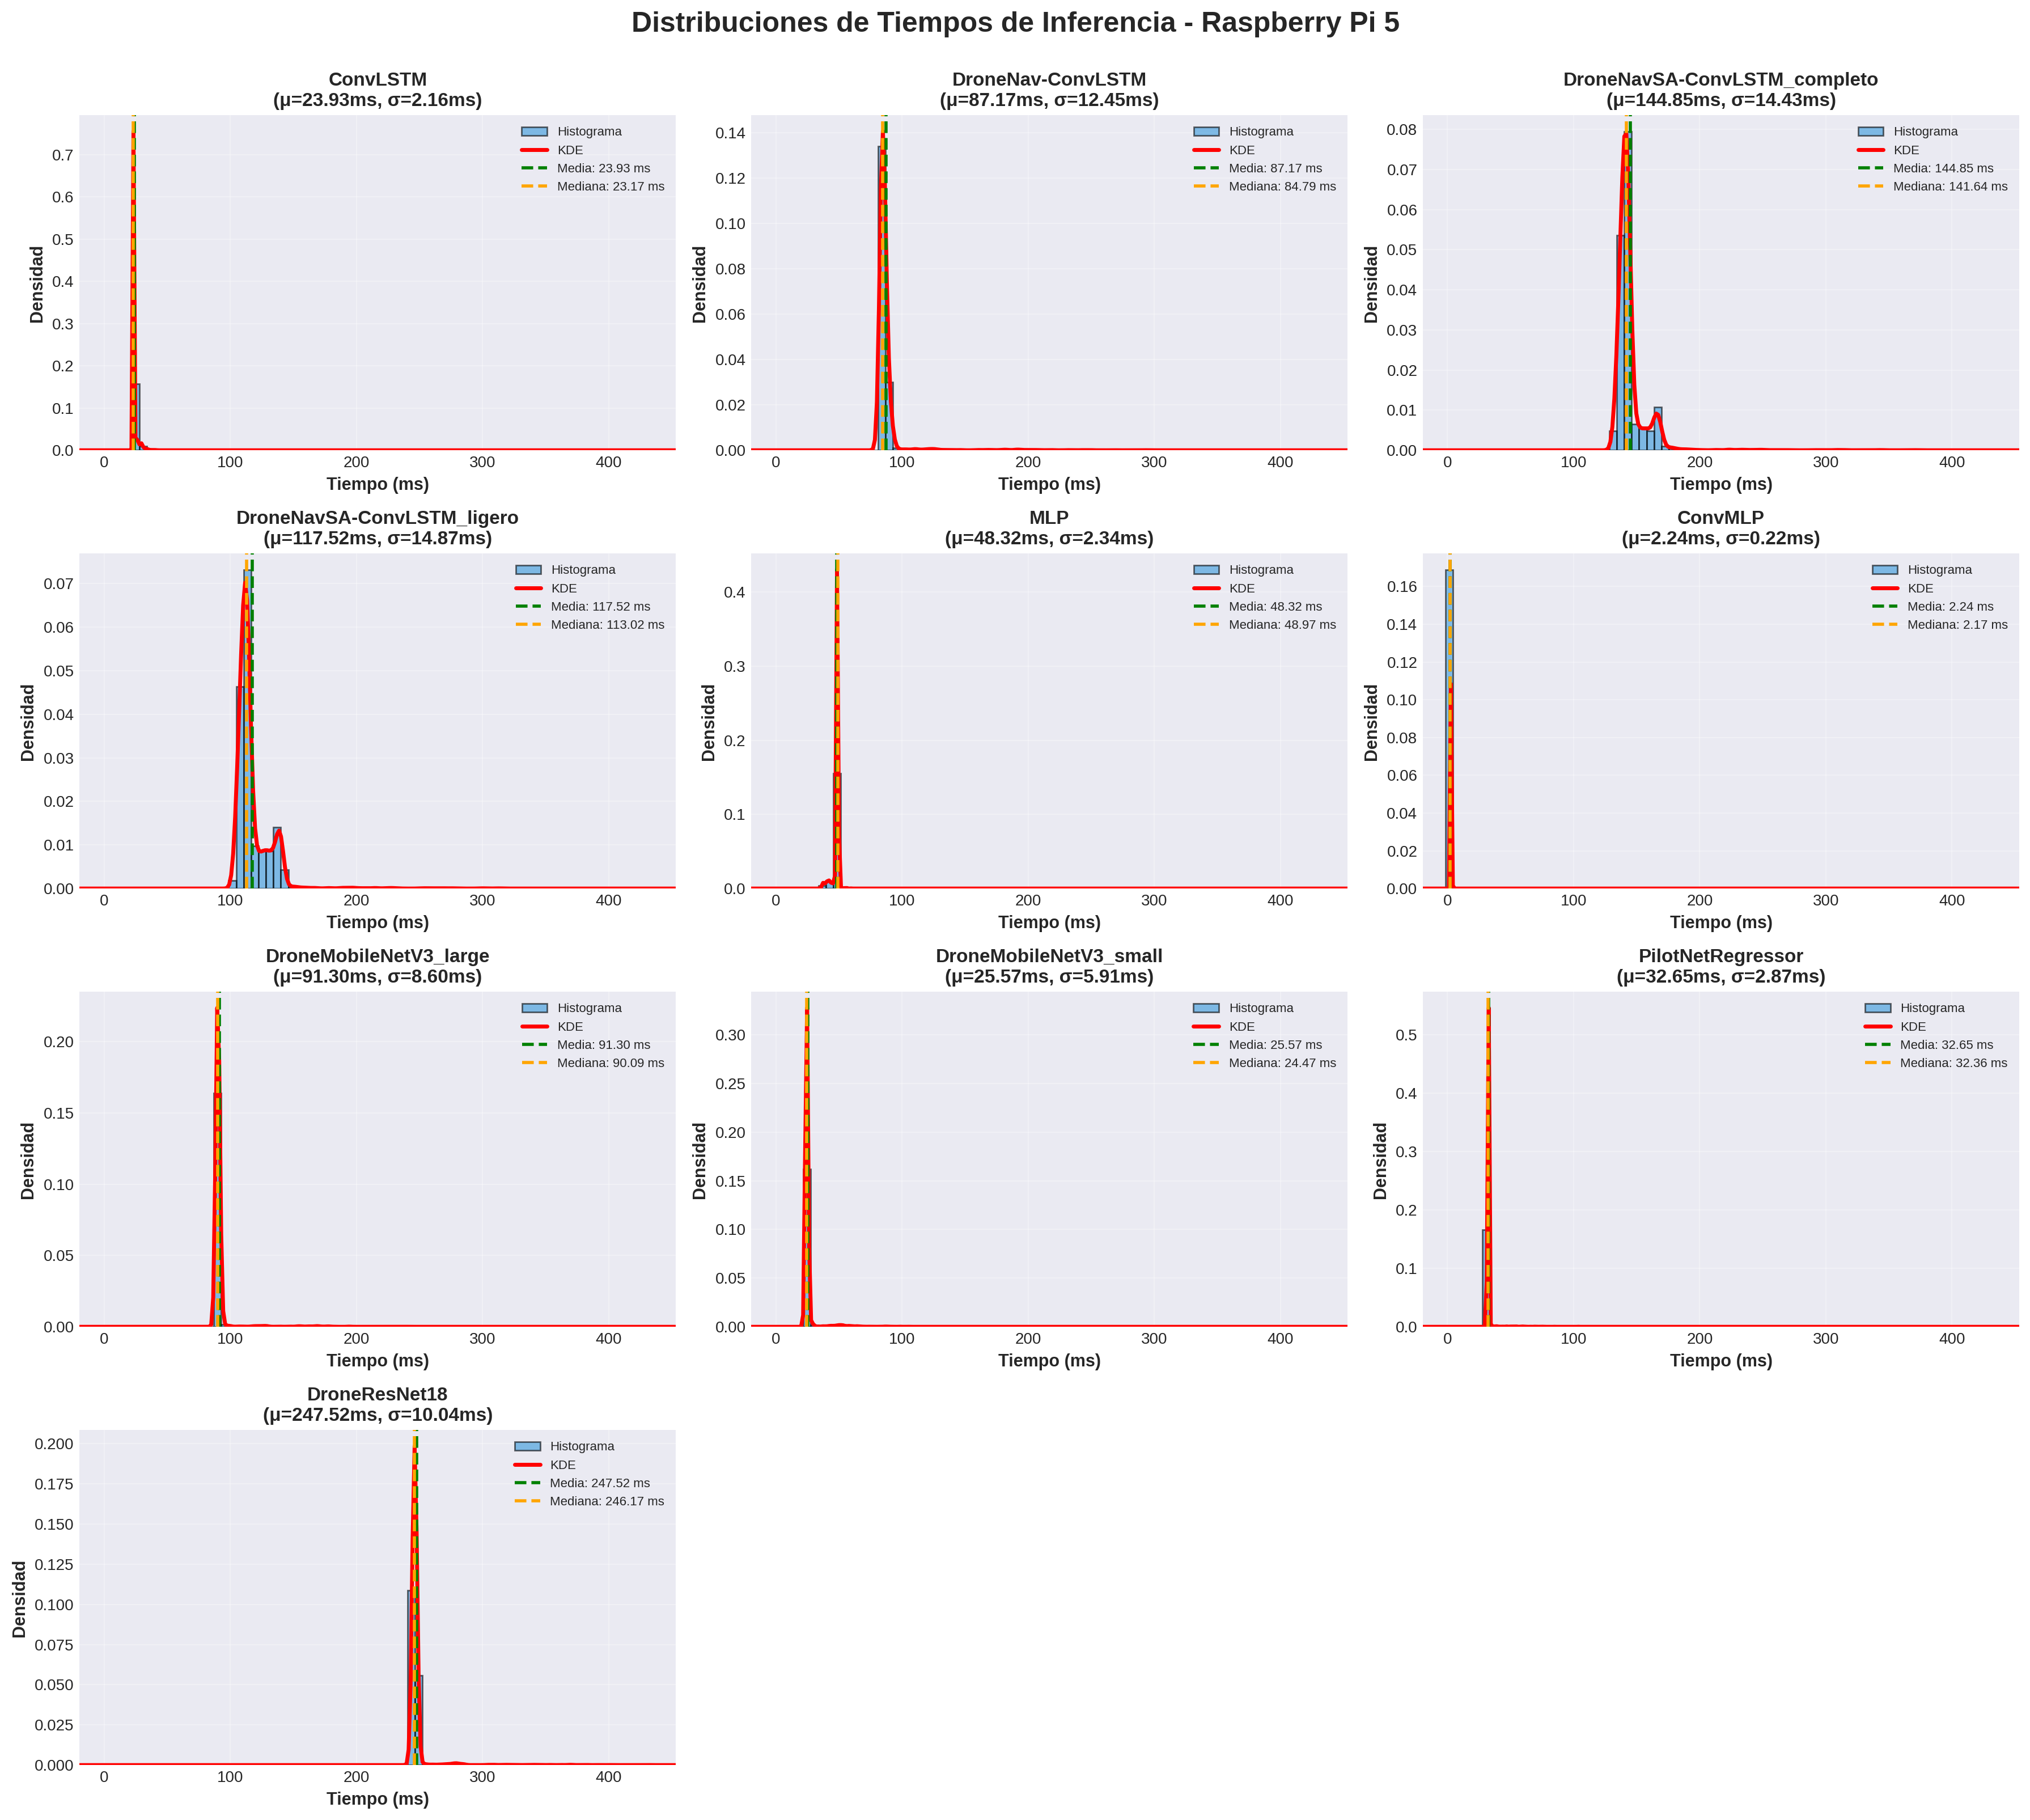

✅ Grid comparativo guardado: grid_inference_times_rpi5.png


In [12]:
# ============================================================================
# 📊 GRID COMPARATIVO DE HISTOGRAMAS
# ============================================================================

from scipy import stats
import math

n_models = len(all_results)
n_cols = 3
n_rows = math.ceil(n_models / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten() if n_models > 1 else [axes]

x_range = np.linspace(X_LIMIT_MIN, X_LIMIT_MAX, 300)  # ← RANGO COMÚN

for idx, (model_name, results) in enumerate(all_results.items()):
    inference_times = results['inference_times']
    
    # Histograma con KDE
    axes[idx].hist(inference_times, bins=80, color='#3498db', alpha=0.6, 
                   edgecolor='black', density=True, label='Histograma',
                   range=(X_LIMIT_MIN, X_LIMIT_MAX))
    
    # KDE
    kde = stats.gaussian_kde(inference_times)
    #x_range = np.linspace(min(inference_times), max(inference_times), 200)
    axes[idx].plot(x_range, kde(x_range), 'r-', linewidth=2.5, label='KDE')
    
    # Líneas de estadísticas
    axes[idx].axvline(np.mean(inference_times), color='green', linestyle='--', 
                     linewidth=2, label=f'Media: {np.mean(inference_times):.2f} ms')
    axes[idx].axvline(np.median(inference_times), color='orange', linestyle='--', 
                     linewidth=2, label=f'Mediana: {np.median(inference_times):.2f} ms')
    
    axes[idx].set_xlim(X_LIMIT_MIN, X_LIMIT_MAX)
    axes[idx].set_xlabel('Tiempo (ms)', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Densidad', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{model_name}\n(μ={np.mean(inference_times):.2f}ms, σ={np.std(inference_times):.2f}ms)', 
                       fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=8, loc='upper right')
    axes[idx].grid(True, alpha=0.3)

# Ocultar subplots vacíos
for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.suptitle(f'Distribuciones de Tiempos de Inferencia - {HARDWARE_NAME}', 
             fontsize=18, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(f'grid_inference_times_{HARDWARE_TYPE}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Grid comparativo guardado: grid_inference_times_{HARDWARE_TYPE}.png")

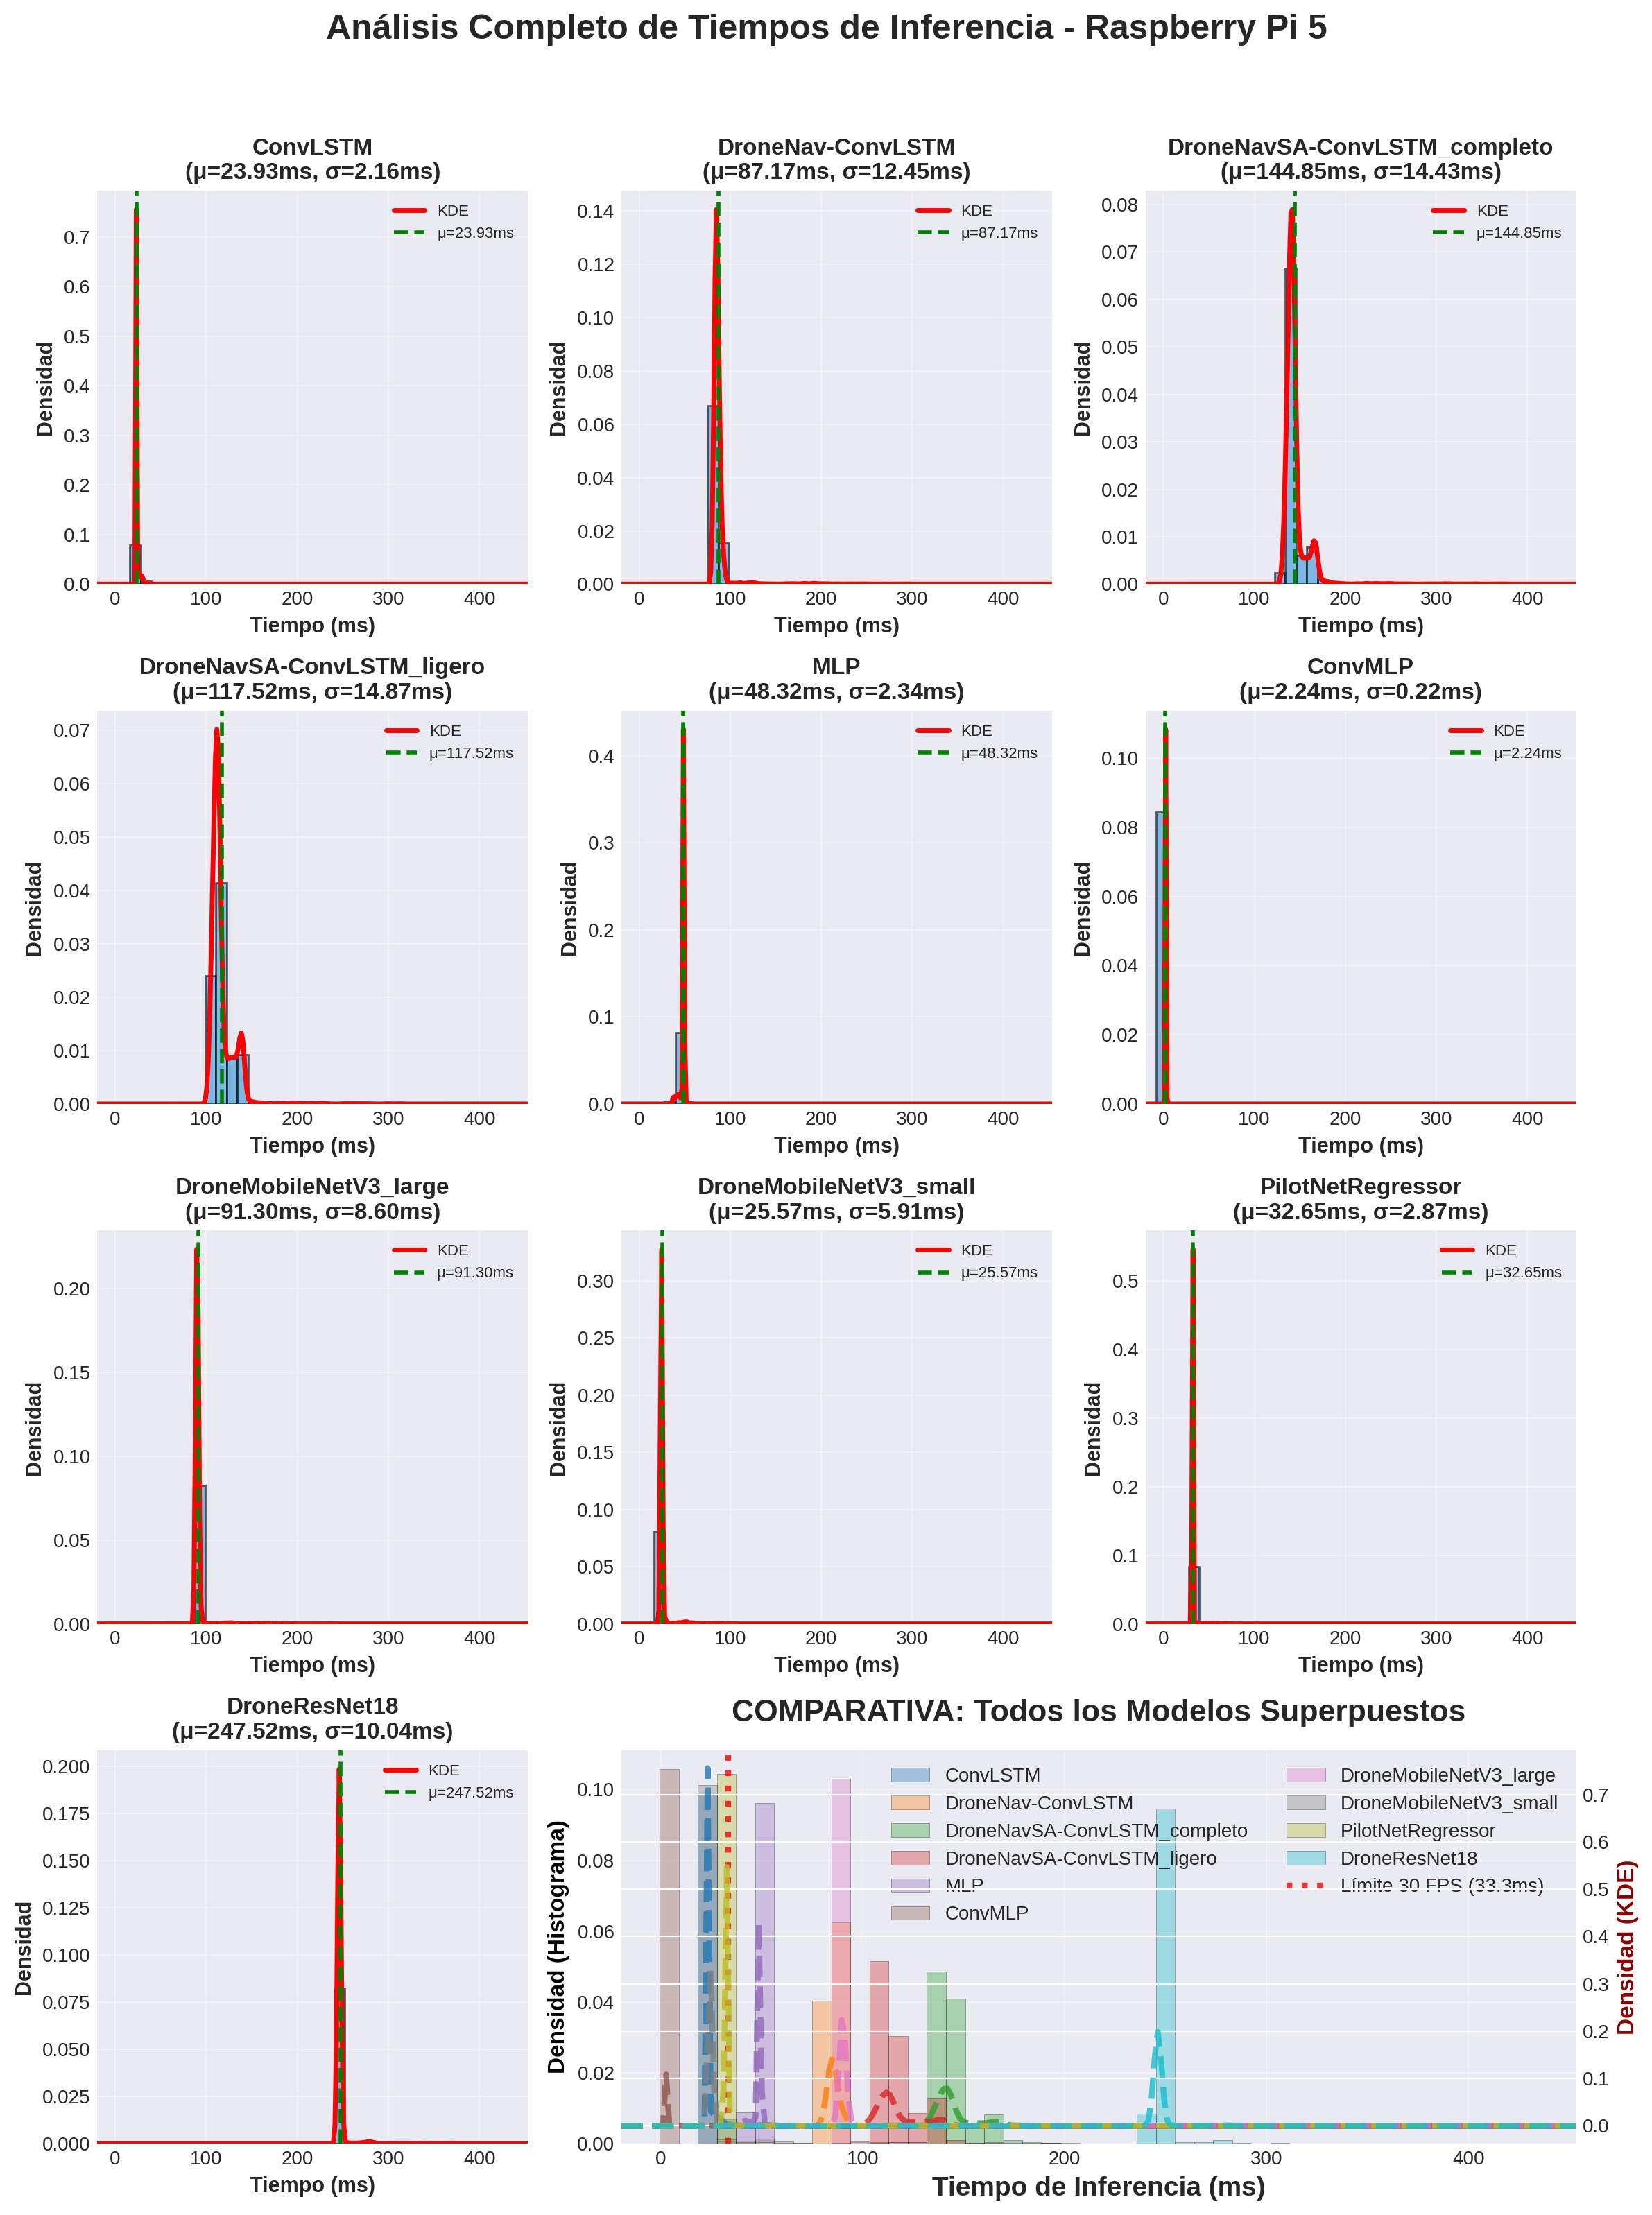

✅ Grid con comparativa guardado: grid_complete_comparison_rpi5.png


In [13]:
# ============================================================================
# 📊 GRID COMPARATIVO (3x4) + COMPARATIVA EN ESPACIO LIBRE
# ============================================================================

from scipy import stats
import math

n_models = len(all_results)
n_cols = 3
n_rows = math.ceil(n_models / n_cols)  # 4 filas para 10 modelos

fig = plt.figure(figsize=(12, n_rows * 4))

x_range = np.linspace(X_LIMIT_MIN, X_LIMIT_MAX, 300)
colors_individual = plt.cm.tab10(np.linspace(0, 1, n_models))

# ============================================================================
# PARTE 1: Gráficas individuales de cada modelo
# ============================================================================
for idx, (model_name, results) in enumerate(all_results.items()):
    inference_times = results['inference_times']
    row = idx // n_cols
    col = idx % n_cols
    
    ax = plt.subplot2grid((n_rows, n_cols), (row, col))
    
    ax.hist(inference_times, bins=40, color='#3498db', alpha=0.6, 
            edgecolor='black', density=True, range=(X_LIMIT_MIN, X_LIMIT_MAX))
    
    kde = stats.gaussian_kde(inference_times)
    ax.plot(x_range, kde(x_range), 'r-', linewidth=2.5, label='KDE')
    
    ax.axvline(np.mean(inference_times), color='green', linestyle='--', 
               linewidth=2, label=f'μ={np.mean(inference_times):.2f}ms')
    
    ax.set_xlim(X_LIMIT_MIN, X_LIMIT_MAX)
    ax.set_xlabel('Tiempo (ms)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Densidad', fontsize=11, fontweight='bold')
    ax.set_title(f'{model_name}\n(μ={np.mean(inference_times):.2f}ms, σ={np.std(inference_times):.2f}ms)', 
                 fontsize=12, fontweight='bold')
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(True, alpha=0.3)

# ============================================================================
# PARTE 2: COMPARATIVA - Ocupa las 2 columnas libres de la última fila
# ============================================================================
# Calcular posición de la comparativa (columnas libres en la última fila)
last_model_col = (n_models - 1) % n_cols  # Columna del último modelo
comparison_start_col = last_model_col + 1  # Empieza después del último modelo
comparison_colspan = n_cols - comparison_start_col  # Columnas disponibles

ax_comparison = plt.subplot2grid((n_rows, n_cols), (n_rows-1, comparison_start_col), 
                                colspan=comparison_colspan)

# Crear dos ejes Y compartiendo el mismo X
ax_kde = ax_comparison.twinx()

# En ax_comparison: Histogramas superpuestos
for idx, (model_name, results) in enumerate(all_results.items()):
    inference_times = results['inference_times']
    ax_comparison.hist(inference_times, bins=50, alpha=0.35, label=model_name,
                      color=colors_individual[idx], edgecolor='black', linewidth=0.3,
                      range=(X_LIMIT_MIN, X_LIMIT_MAX), density=True)

# En ax_kde: Curvas KDE superpuestas
for idx, (model_name, results) in enumerate(all_results.items()):
    inference_times = results['inference_times']
    kde = stats.gaussian_kde(inference_times)
    ax_kde.plot(x_range, kde(x_range), linewidth=3, color=colors_individual[idx], 
               linestyle='--', alpha=0.8)

# Configurar ejes
ax_comparison.set_xlim(X_LIMIT_MIN, X_LIMIT_MAX)
ax_comparison.set_xlabel('Tiempo de Inferencia (ms)', fontsize=14, fontweight='bold')
ax_comparison.set_ylabel('Densidad (Histograma)', fontsize=12, fontweight='bold', color='black')
ax_kde.set_ylabel('Densidad (KDE)', fontsize=12, fontweight='bold', color='darkred')

# Línea de 30 FPS
ax_comparison.axvline(33.3, color='red', linestyle=':', linewidth=3, 
                     label='Límite 30 FPS (33.3ms)', alpha=0.8)

ax_comparison.set_title('COMPARATIVA: Todos los Modelos Superpuestos', 
                       fontsize=16, fontweight='bold', pad=15)
ax_comparison.legend(loc='upper right', fontsize=10, ncol=2, framealpha=0.95)
ax_comparison.grid(True, alpha=0.3)

# ============================================================================
# Título general y guardar
# ============================================================================
plt.suptitle(f'Análisis Completo de Tiempos de Inferencia - {HARDWARE_NAME}\n', 
             fontsize=18, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig(f'grid_complete_comparison_{HARDWARE_TYPE}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Grid con comparativa guardado: grid_complete_comparison_{HARDWARE_TYPE}.png")

## 📊 10. Tabla Comparativa: Precisión y Rendimiento

In [15]:
# Crear DataFrame combinado
comparison_data = []

for model_name, results in all_results.items():
    comparison_data.append({
        'Modelo': model_name,
        'RMSE': results['metrics']['global']['RMSE'],
        'MAE': results['metrics']['global']['MAE'],
        'R²': results['metrics']['global']['R2'],
        'Latencia (ms)': results['single_perf']['mean_ms'],
        'Std (ms)': results['single_perf']['std_ms'],
        'P95 (ms)': results['single_perf']['p95_ms'],
        'FPS': results['single_perf']['fps'],
        'Tamaño (MB)': results['model_size_mb'],
        'Multi-Step': '✓' if results.get('multi_step', False) else ''
    })

df_comparison = pd.DataFrame(comparison_data)
df_comparison = df_comparison.sort_values('RMSE')

print("\n📊 TABLA COMPARATIVA - PRECISIÓN Y RENDIMIENTO")
print("="*110)
print(df_comparison.to_string(index=False))
print("="*110)

# Mejor modelo por precisión
best_accuracy = df_comparison.iloc[0]['Modelo']
print(f"\n🎯 MEJOR PRECISIÓN: {best_accuracy}")
print(f"   RMSE: {df_comparison.iloc[0]['RMSE']:.6f}")

# Modelo más rápido
fastest_model = df_comparison.sort_values('Latencia (ms)').iloc[0]['Modelo']
print(f"\n⚡ MÁS RÁPIDO: {fastest_model}")
print(f"   Latencia: {df_comparison.sort_values('Latencia (ms)').iloc[0]['Latencia (ms)']:.2f} ms")

# Modelo más pequeño
smallest_model = df_comparison.sort_values('Tamaño (MB)').iloc[0]['Modelo']
print(f"\n💾 MÁS COMPACTO: {smallest_model}")
print(f"   Tamaño: {df_comparison.sort_values('Tamaño (MB)').iloc[0]['Tamaño (MB)']:.2f} MB")


📊 TABLA COMPARATIVA - PRECISIÓN Y RENDIMIENTO
                      Modelo     RMSE      MAE       R²  Latencia (ms)  Std (ms)   P95 (ms)        FPS  Tamaño (MB) Multi-Step
      DroneMobileNetV3_large 0.371707 0.214393 0.853392      91.023275  0.630008  91.882799  10.986201    19.679760           
  DroneNavSA-ConvLSTM_ligero 0.374790 0.229981 0.851418     117.055898 18.294605 139.659046   8.542927     6.882374           
           PilotNetRegressor 0.375368 0.221603 0.850738      32.624202  2.829315  32.615328  30.652091    53.361041           
DroneNavSA-ConvLSTM_completo 0.377404 0.233805 0.849806     140.018382 18.292290 142.277166   7.141919     6.763458           
               DroneResNet18 0.381545 0.215092 0.845947     250.594925 18.148496 271.609467   3.990504    49.206033           
           DroneNav-ConvLSTM 0.382869 0.235531 0.844988      84.230152  0.848636  85.083048  11.872233     5.204607           
      DroneMobileNetV3_small 0.390485 0.233527 0.838493      24.

## 📈 11. Visualización: Latencia vs Precisión

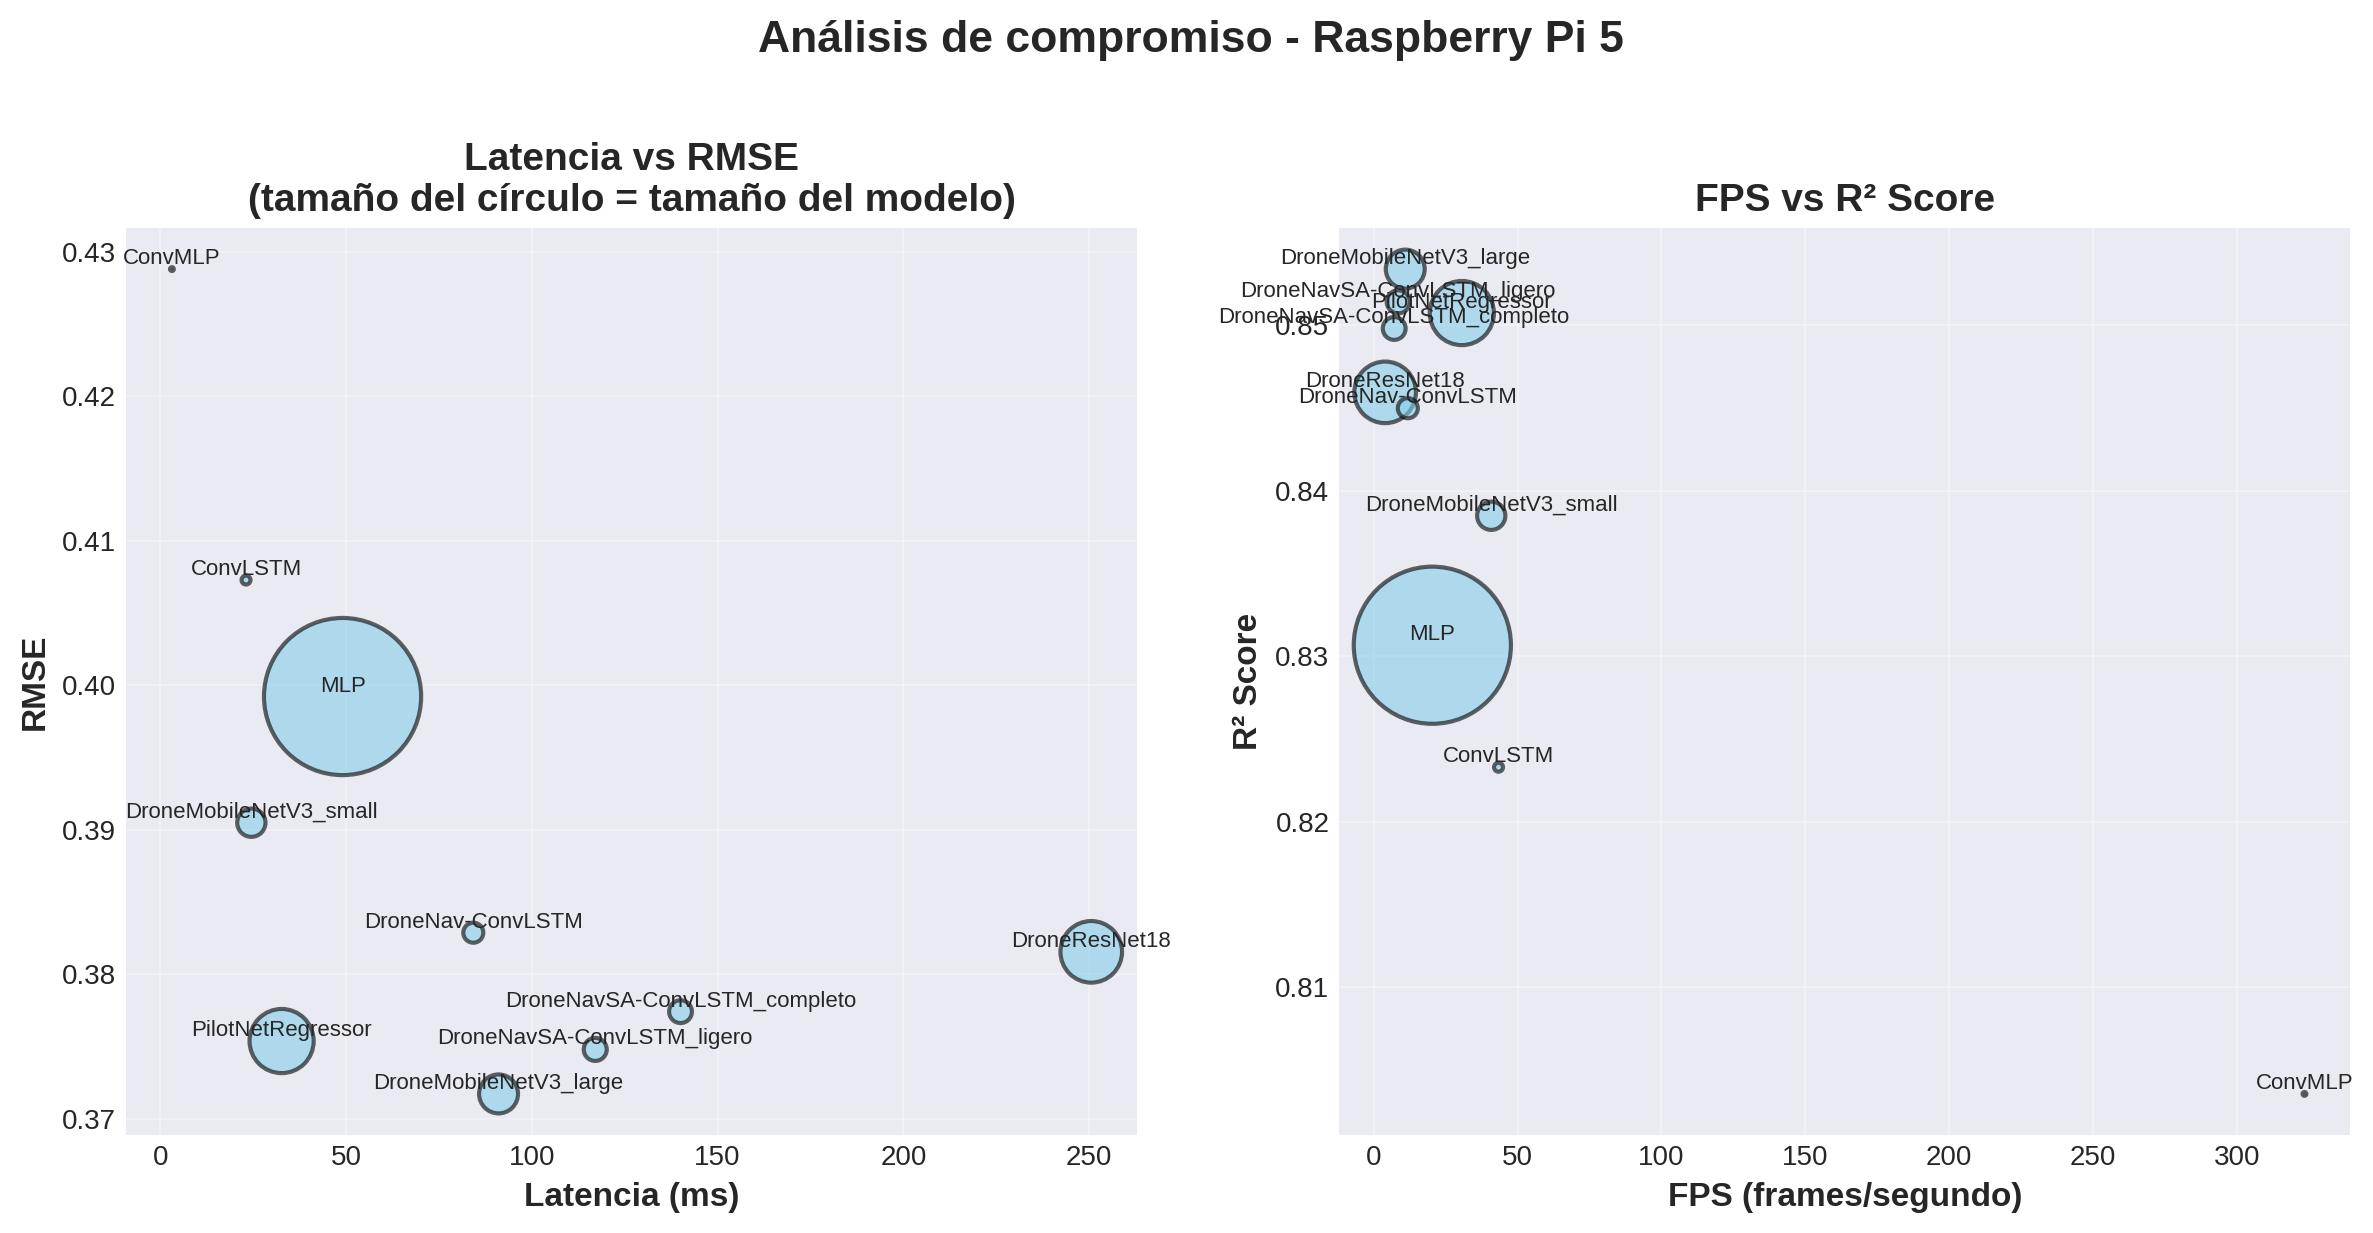

✅ Gráfica guardada: latency_vs_accuracy_rpi5.png


In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Latencia vs RMSE
colors = ['orange' if row['Multi-Step'] == '✓' else 'skyblue' for _, row in df_comparison.iterrows()]
sizes = df_comparison['Tamaño (MB)'] * 10

scatter1 = axes[0].scatter(df_comparison['Latencia (ms)'], df_comparison['RMSE'], 
                          c=colors, s=sizes, alpha=0.6, edgecolors='black', linewidth=1.5)

# Etiquetas
for idx, row in df_comparison.iterrows():
    axes[0].annotate(row['Modelo'], 
                    (row['Latencia (ms)'], row['RMSE']),
                    fontsize=8, ha='center', va='bottom')

axes[0].set_xlabel('Latencia (ms)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('RMSE', fontsize=12, fontweight='bold')
axes[0].set_title('Latencia vs RMSE\n(tamaño del círculo = tamaño del modelo)', 
                 fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# FPS vs R²
scatter2 = axes[1].scatter(df_comparison['FPS'], df_comparison['R²'], 
                          c=colors, s=sizes, alpha=0.6, edgecolors='black', linewidth=1.5)

for idx, row in df_comparison.iterrows():
    axes[1].annotate(row['Modelo'], 
                    (row['FPS'], row['R²']),
                    fontsize=8, ha='center', va='bottom')

axes[1].set_xlabel('FPS (frames/segundo)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[1].set_title('FPS vs R² Score', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

# Leyenda
from matplotlib.patches import Patch
#legend_elements = [
#    Patch(facecolor='skyblue', label='Single-step'),
#    Patch(facecolor='orange', label='Multi-step')
#]
#axes[1].legend(handles=legend_elements, loc='lower right')

plt.suptitle(f'Análisis de compromiso - {HARDWARE_NAME}', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'latency_vs_accuracy_{HARDWARE_TYPE}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Gráfica guardada: latency_vs_accuracy_{HARDWARE_TYPE}.png")

## ⏱️ 12. Distribución de Latencias

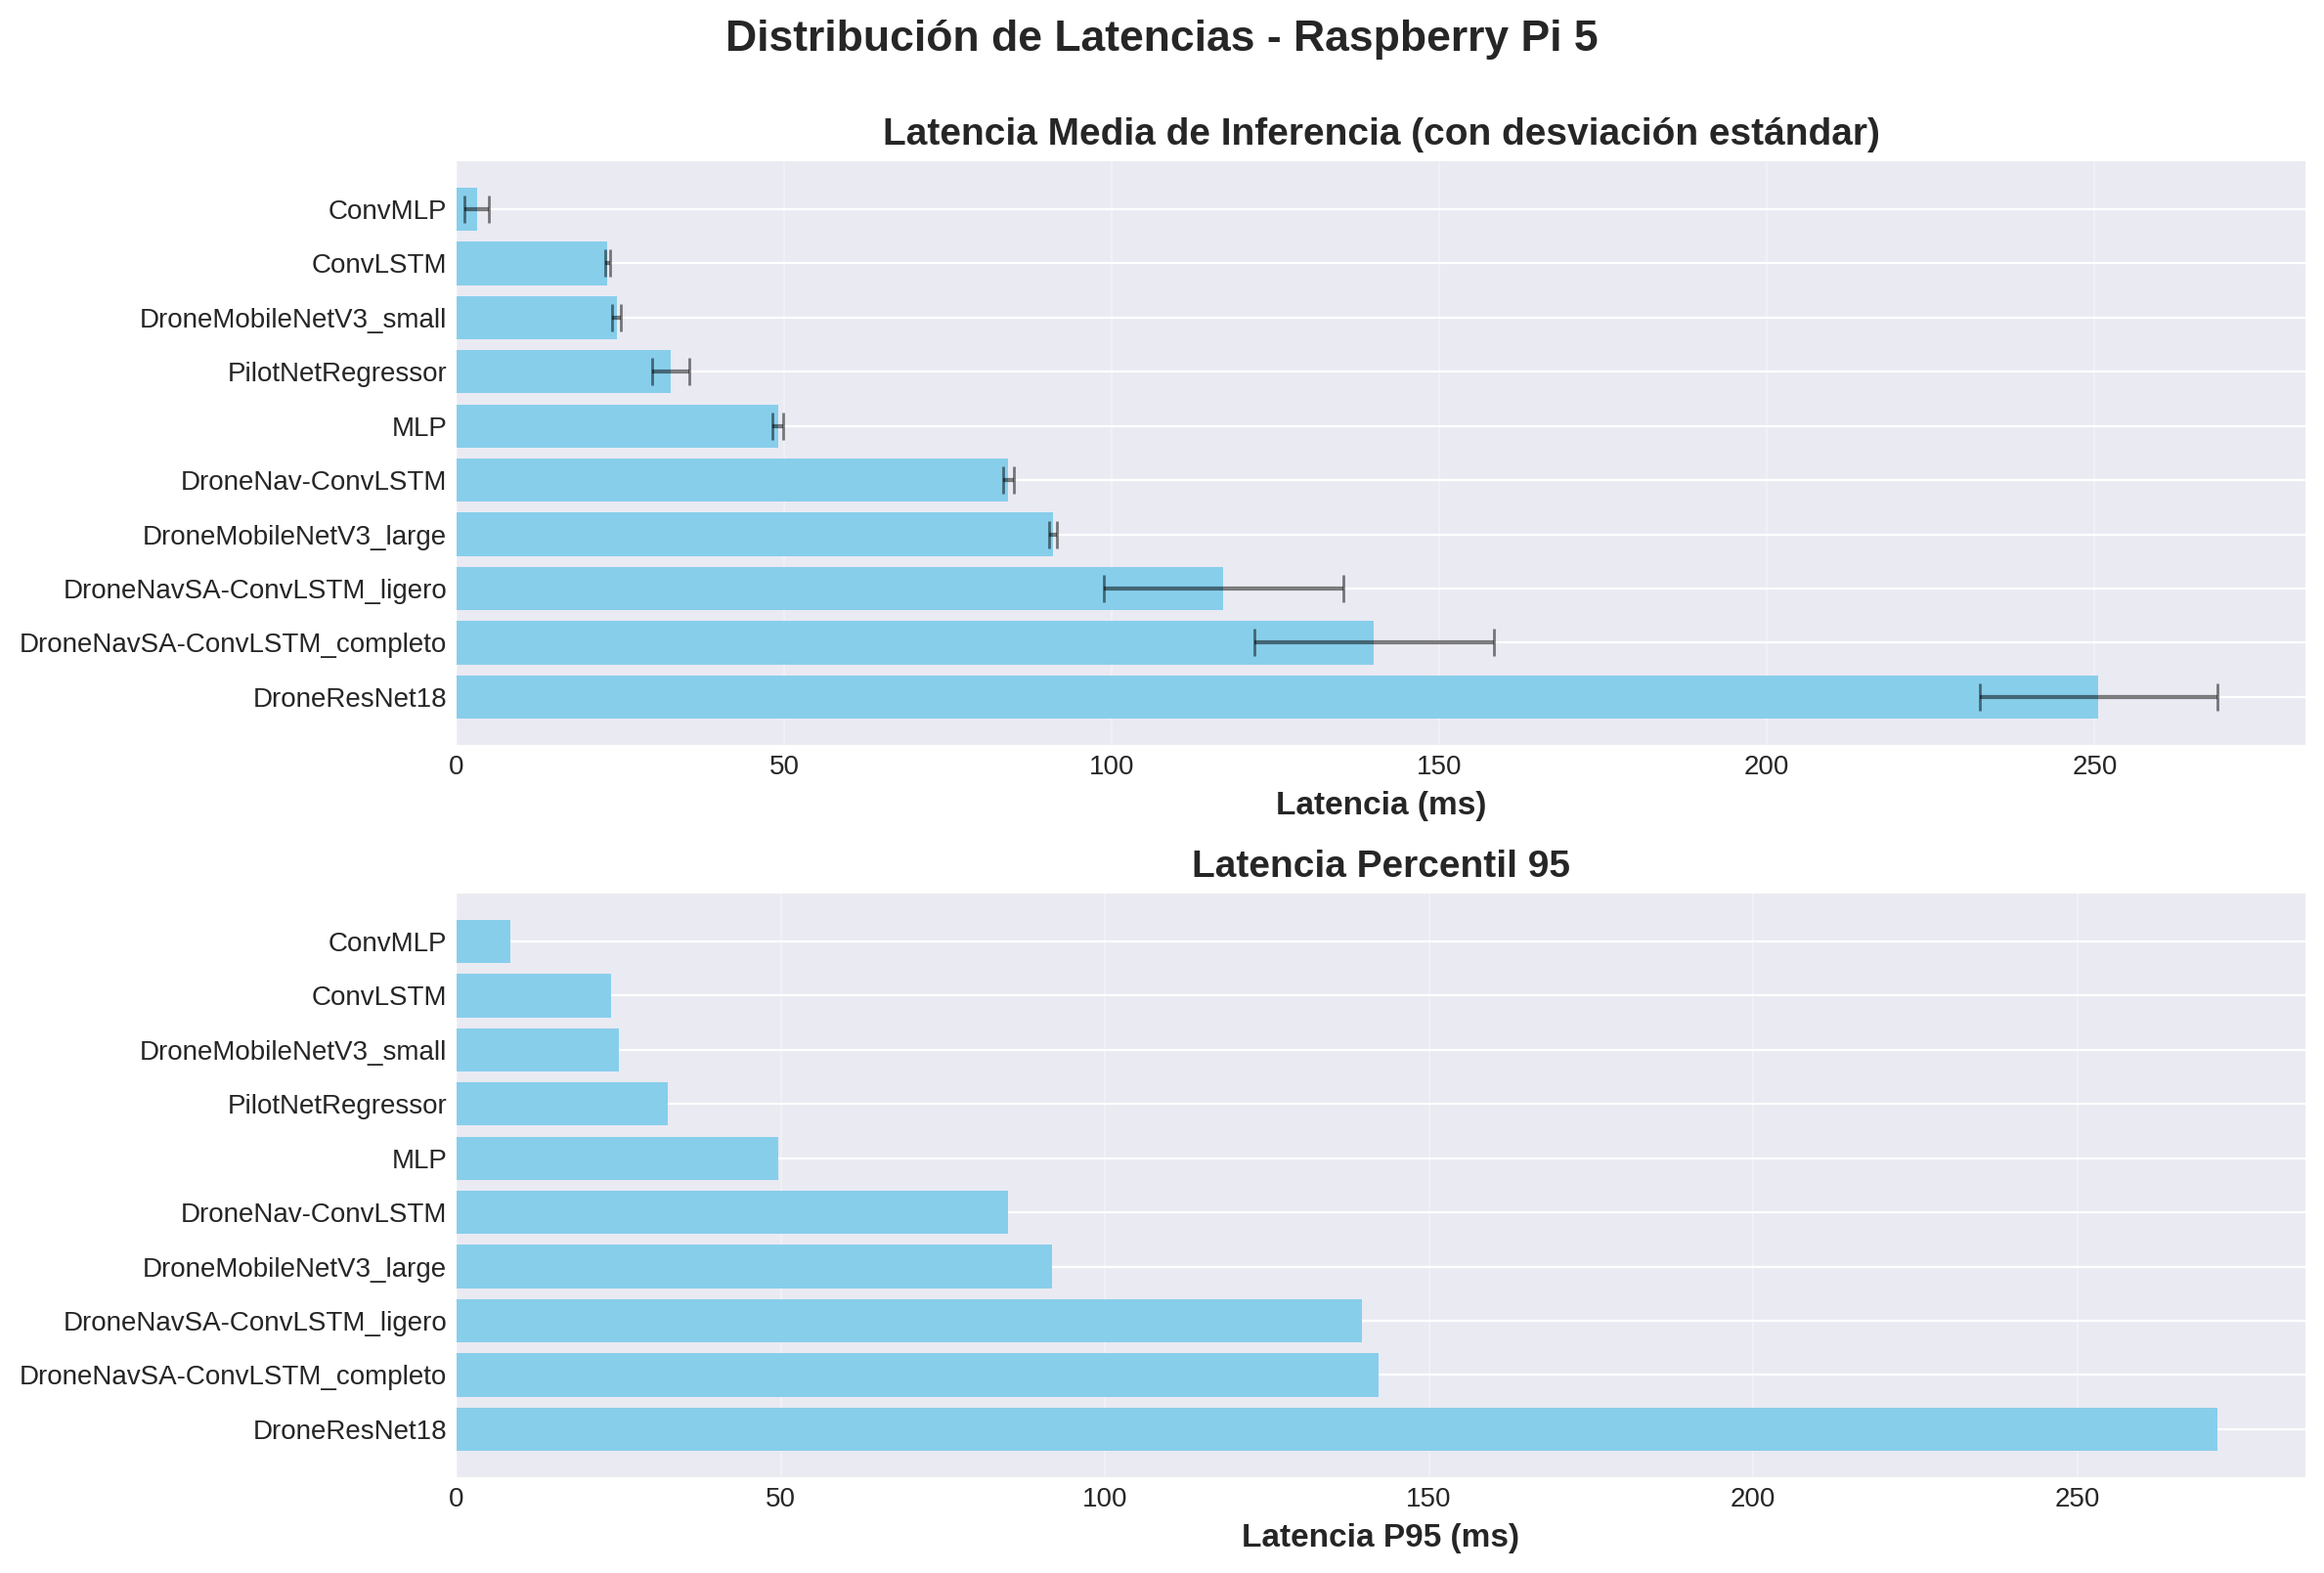

✅ Gráfica guardada: latency_distribution_rpi5.png


In [18]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Gráfica de barras: latencia media
df_sorted = df_comparison.sort_values('Latencia (ms)')
colors = ['orange' if m == '✓' else 'skyblue' for m in df_sorted['Multi-Step']]

bars = axes[0].barh(df_sorted['Modelo'], df_sorted['Latencia (ms)'], color=colors)

# Agregar barras de error (std)
axes[0].errorbar(df_sorted['Latencia (ms)'], range(len(df_sorted)), 
                xerr=df_sorted['Std (ms)'], fmt='none', ecolor='black', 
                capsize=5, alpha=0.5)

axes[0].set_xlabel('Latencia (ms)', fontsize=12, fontweight='bold')
axes[0].set_title('Latencia Media de Inferencia (con desviación estándar)', 
                 fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# Gráfica de barras: P95 latency
bars = axes[1].barh(df_sorted['Modelo'], df_sorted['P95 (ms)'], color=colors)
axes[1].set_xlabel('Latencia P95 (ms)', fontsize=12, fontweight='bold')
axes[1].set_title('Latencia Percentil 95', 
                 fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

plt.suptitle(f'Distribución de Latencias - {HARDWARE_NAME}', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(f'latency_distribution_{HARDWARE_TYPE}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Gráfica guardada: latency_distribution_{HARDWARE_TYPE}.png")

## 📊 13. Comparación de Tamaño de Modelos

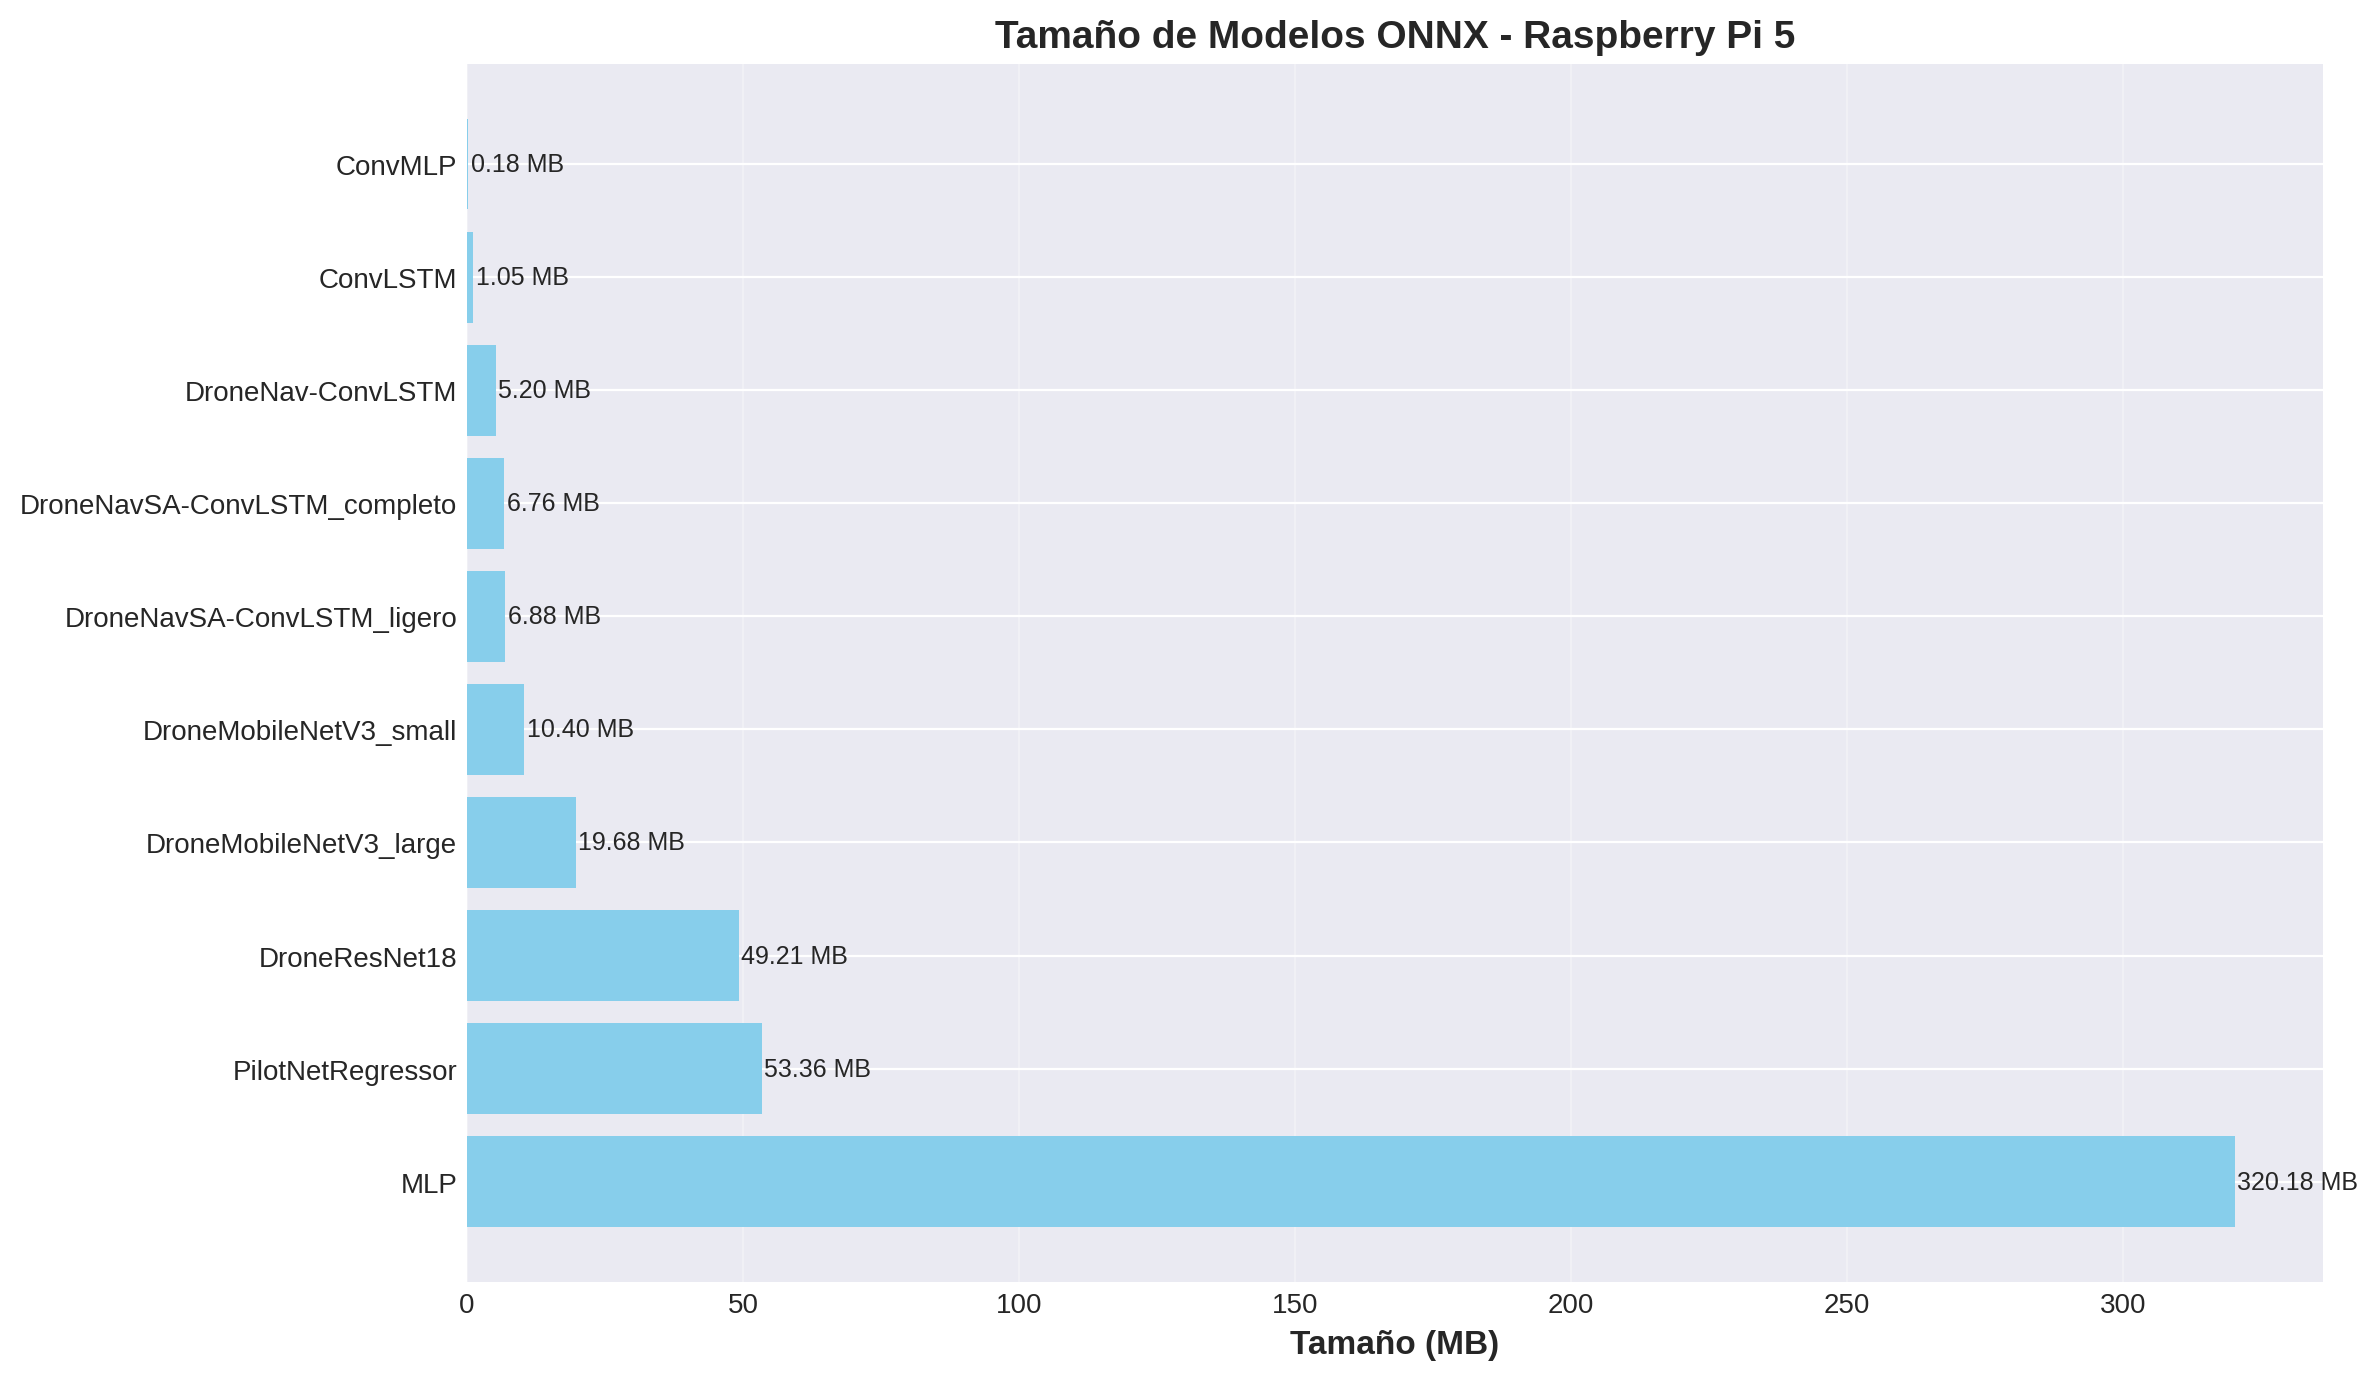

✅ Gráfica guardada: model_sizes_rpi5.png


In [19]:
fig, ax = plt.subplots(figsize=(12, 7))

df_sorted = df_comparison.sort_values('Tamaño (MB)')
colors = ['orange' if m == '✓' else 'skyblue' for m in df_sorted['Multi-Step']]

bars = ax.barh(df_sorted['Modelo'], df_sorted['Tamaño (MB)'], color=colors)

# Añadir etiquetas con valores
for i, (idx, row) in enumerate(df_sorted.iterrows()):
    ax.text(row['Tamaño (MB)'] + 0.5, i, f"{row['Tamaño (MB)']:.2f} MB", 
           va='center', fontsize=9)

ax.set_xlabel('Tamaño (MB)', fontsize=12, fontweight='bold')
ax.set_title(f'Tamaño de Modelos ONNX - {HARDWARE_NAME}', 
            fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()

# Leyenda
legend_elements = [
    Patch(facecolor='skyblue', label='Single-step'),
    Patch(facecolor='orange', label='Multi-step')
]
#ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(f'model_sizes_{HARDWARE_TYPE}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Gráfica guardada: model_sizes_{HARDWARE_TYPE}.png")

## 🎯 14. Efficiency Score: Precisión / (Latencia × Tamaño)

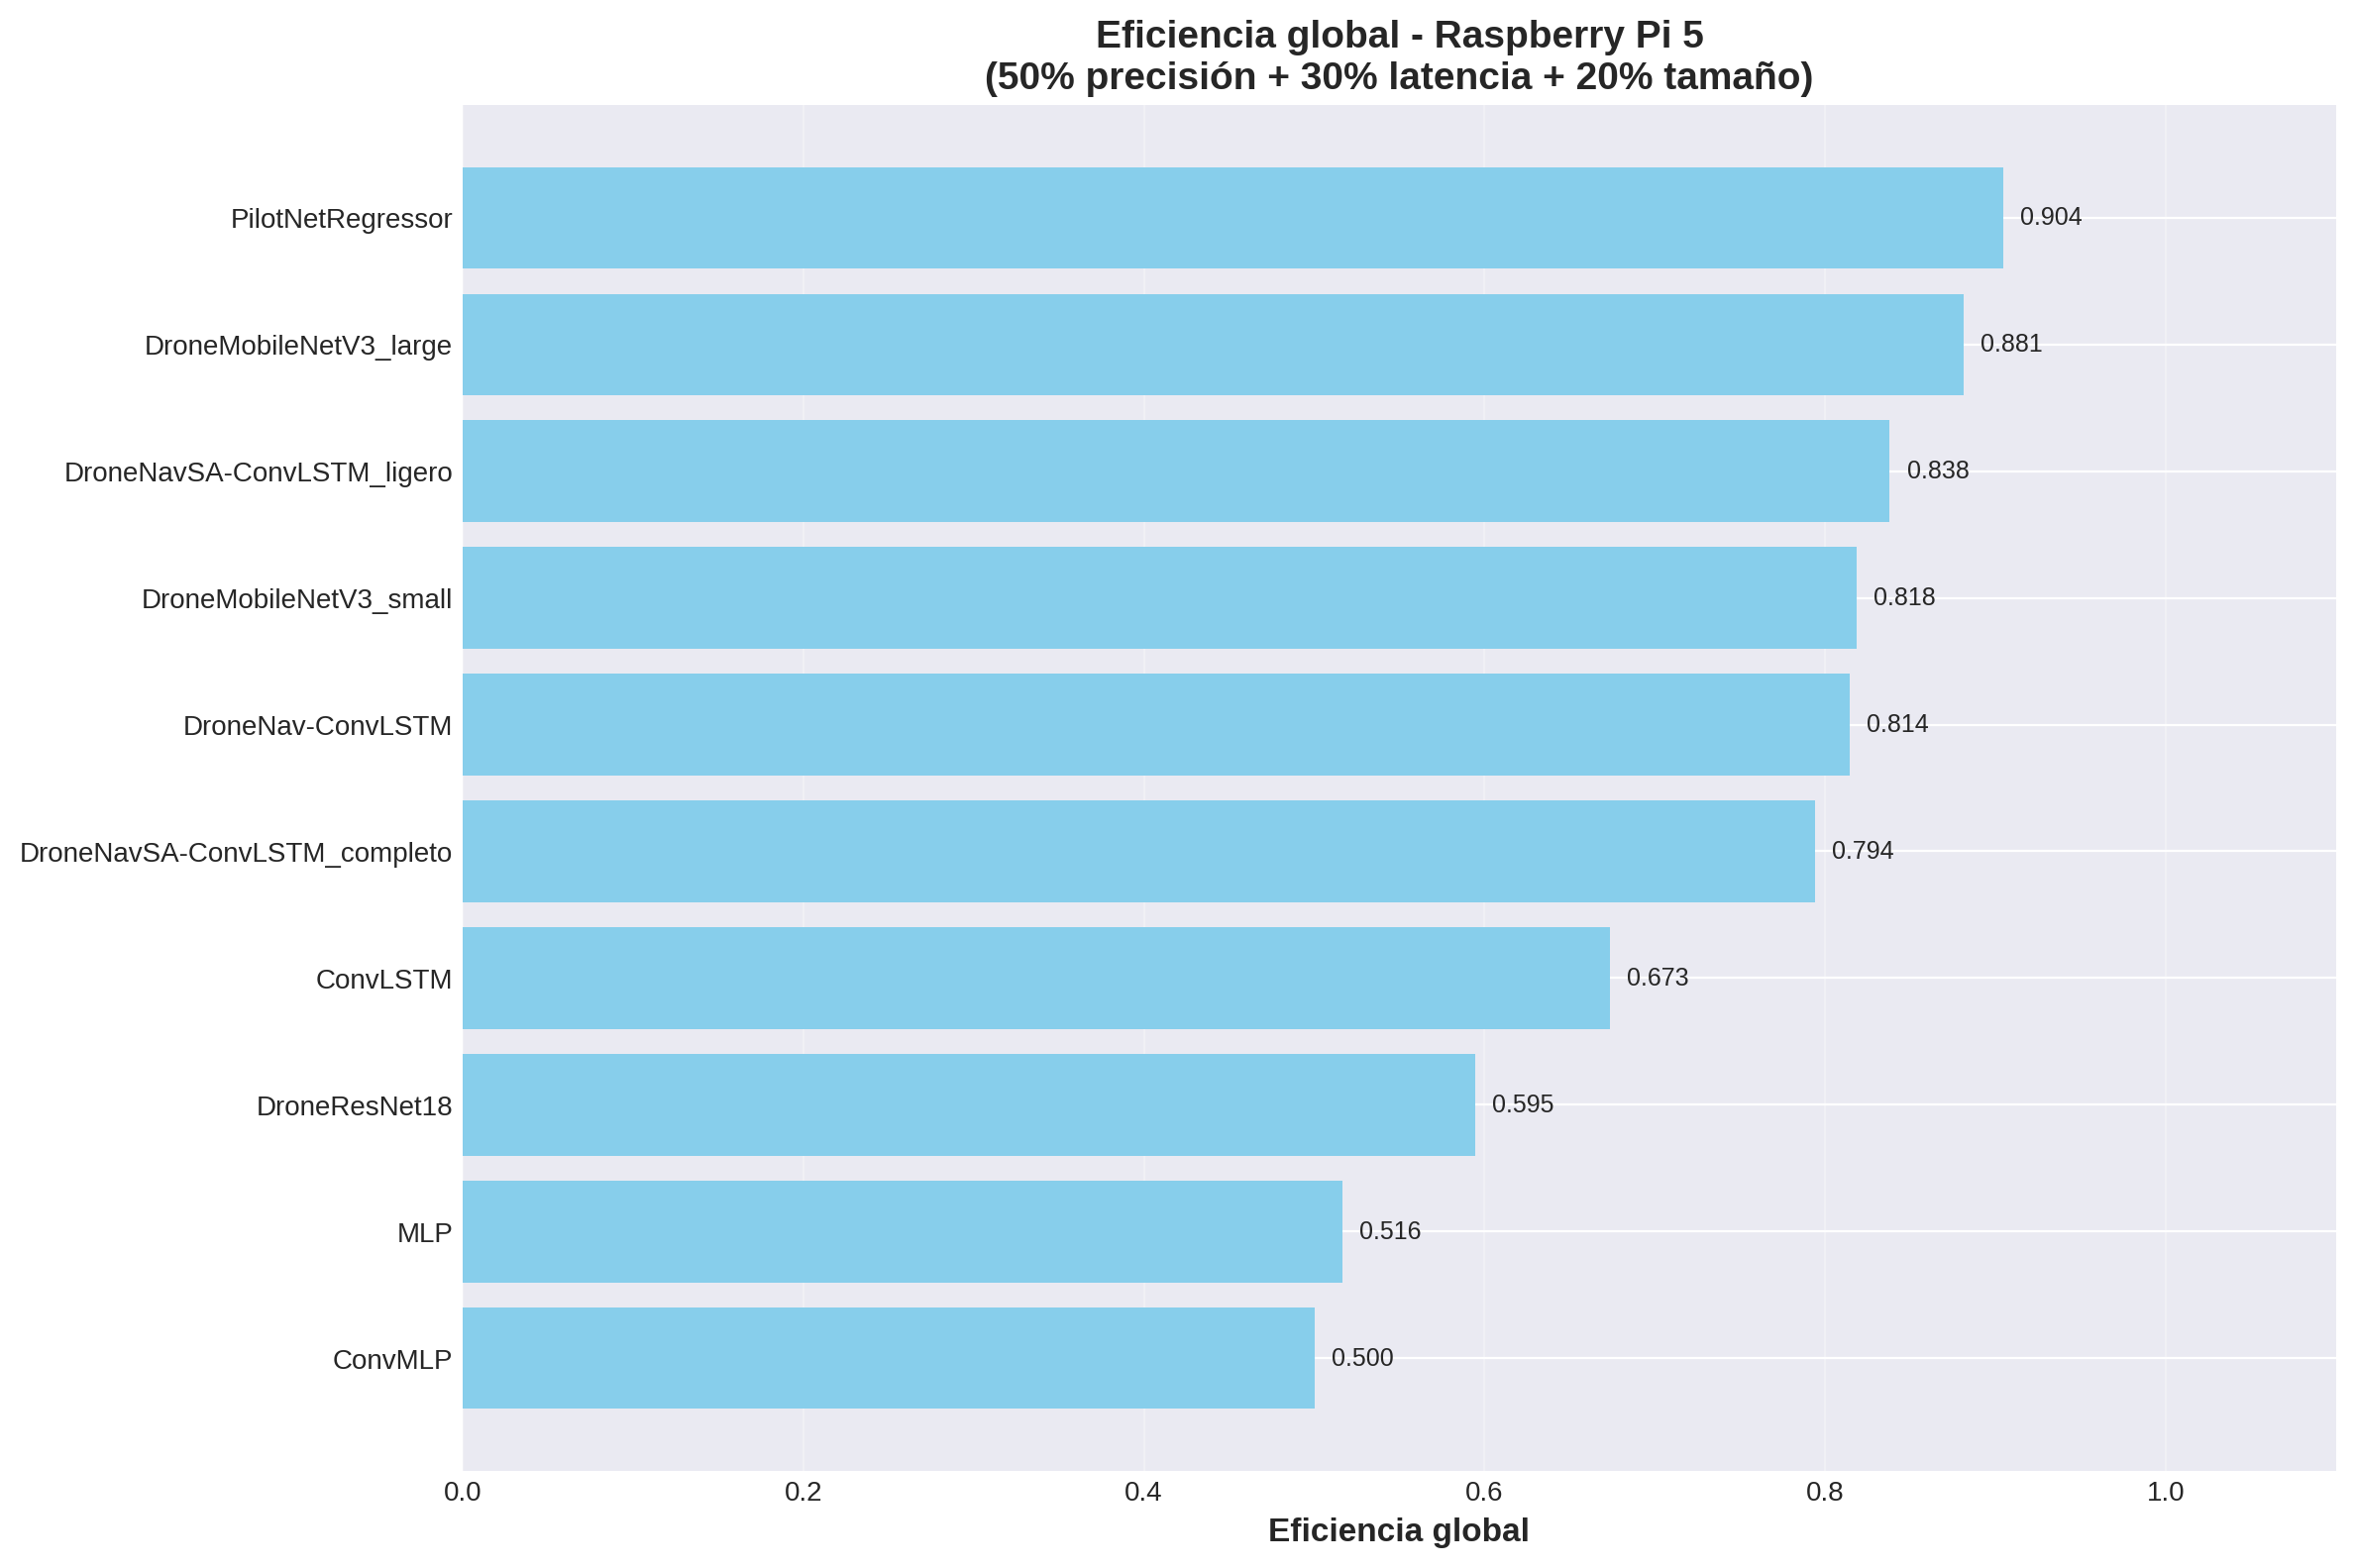

✅ Gráfica guardada: efficiency_score_rpi5.png

🏆 MODELO MÁS EFICIENTE: PilotNetRegressor
   Efficiency Score: 0.904
   RMSE: 0.375368
   Latencia: 32.62 ms
   Tamaño: 53.36 MB


In [25]:
# Calcular efficiency score
# Mayor R² es mejor, menor latencia es mejor, menor tamaño es mejor
# Normalizar todo a [0, 1] y crear un score

df_efficiency = df_comparison.copy()

# Normalizar (invertir latencia y tamaño para que mayor = mejor)
df_efficiency['R2_norm'] = (df_efficiency['R²'] - df_efficiency['R²'].min()) / (df_efficiency['R²'].max() - df_efficiency['R²'].min())
df_efficiency['Latency_norm'] = 1 - ((df_efficiency['Latencia (ms)'] - df_efficiency['Latencia (ms)'].min()) / (df_efficiency['Latencia (ms)'].max() - df_efficiency['Latencia (ms)'].min()))
df_efficiency['Size_norm'] = 1 - ((df_efficiency['Tamaño (MB)'] - df_efficiency['Tamaño (MB)'].min()) / (df_efficiency['Tamaño (MB)'].max() - df_efficiency['Tamaño (MB)'].min()))

# Efficiency Score (pesos: 50% precisión, 30% velocidad, 20% tamaño)
df_efficiency['Efficiency_Score'] = (
    0.5 * df_efficiency['R2_norm'] + 
    0.3 * df_efficiency['Latency_norm'] + 
    0.2 * df_efficiency['Size_norm']
)

df_efficiency = df_efficiency.sort_values('Efficiency_Score', ascending=False)

# Visualizar
fig, ax = plt.subplots(figsize=(12, 8))

colors = ['orange' if m == '✓' else 'skyblue' for m in df_efficiency['Multi-Step']]
bars = ax.barh(df_efficiency['Modelo'], df_efficiency['Efficiency_Score'], color=colors)

# Añadir valores
for i, (idx, row) in enumerate(df_efficiency.iterrows()):
    ax.text(row['Efficiency_Score'] + 0.01, i, f"{row['Efficiency_Score']:.3f}", 
           va='center', fontsize=9)

ax.set_xlabel('Eficiencia global', fontsize=12, fontweight='bold')
ax.set_title(f'Eficiencia global - {HARDWARE_NAME}\n(50% precisión + 30% latencia + 20% tamaño)', 
            fontsize=14, fontweight='bold')
ax.set_xlim(0, 1.1)
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()

# Leyenda
#legend_elements = [
#    Patch(facecolor='skyblue', label='Single-step'),
#    Patch(facecolor='orange', label='Multi-step')
#]
#ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(f'efficiency_score_{HARDWARE_TYPE}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Gráfica guardada: efficiency_score_{HARDWARE_TYPE}.png")

# Mejor modelo por efficiency
best_efficient = df_efficiency.iloc[0]['Modelo']
print(f"\n🏆 MODELO MÁS EFICIENTE: {best_efficient}")
print(f"   Efficiency Score: {df_efficiency.iloc[0]['Efficiency_Score']:.3f}")
print(f"   RMSE: {df_efficiency.iloc[0]['RMSE']:.6f}")
print(f"   Latencia: {df_efficiency.iloc[0]['Latencia (ms)']:.2f} ms")
print(f"   Tamaño: {df_efficiency.iloc[0]['Tamaño (MB)']:.2f} MB")

## 📉 15. Precisión por Dimensión (Mejor Modelo)

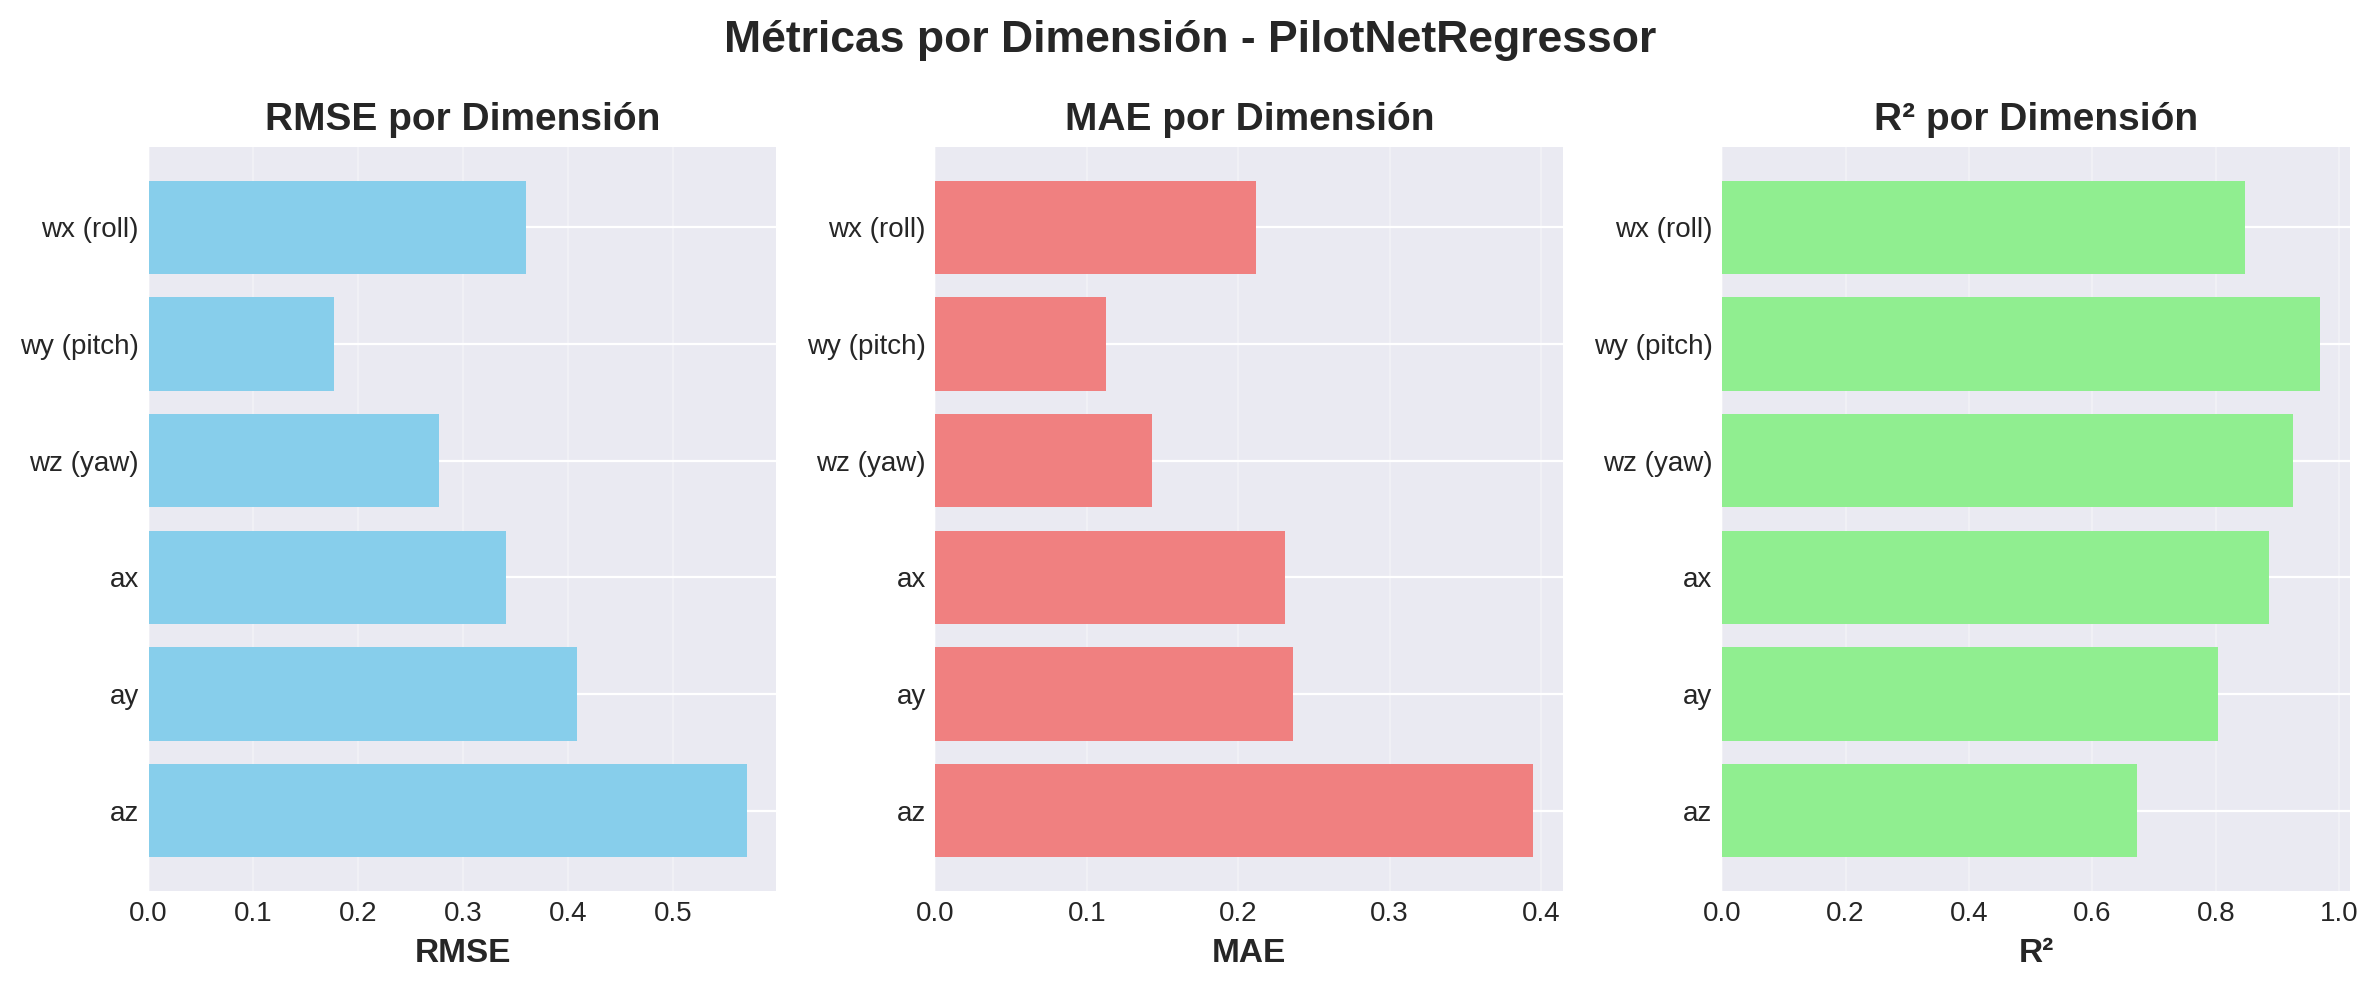

✅ Gráfica guardada: per_dimension_metrics_rpi5.png


In [26]:
# Seleccionar mejor modelo por efficiency
best_model_name = df_efficiency.iloc[0]['Modelo']
best_metrics = all_results[best_model_name]['metrics']

# Extraer RMSE por dimensión
dim_data = []
for dim_name, metrics in best_metrics['per_dimension'].items():
    dim_data.append({
        'Dimensión': dim_name,
        'RMSE': metrics['RMSE'],
        'MAE': metrics['MAE'],
        'R²': metrics['R2']
    })

df_dims = pd.DataFrame(dim_data)

# Visualizar
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# RMSE
axes[0].barh(df_dims['Dimensión'], df_dims['RMSE'], color='skyblue')
axes[0].set_xlabel('RMSE', fontsize=12, fontweight='bold')
axes[0].set_title('RMSE por Dimensión', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# MAE
axes[1].barh(df_dims['Dimensión'], df_dims['MAE'], color='lightcoral')
axes[1].set_xlabel('MAE', fontsize=12, fontweight='bold')
axes[1].set_title('MAE por Dimensión', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

# R²
axes[2].barh(df_dims['Dimensión'], df_dims['R²'], color='lightgreen')
axes[2].set_xlabel('R²', fontsize=12, fontweight='bold')
axes[2].set_title('R² por Dimensión', fontsize=14, fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)
axes[2].invert_yaxis()

plt.suptitle(f'Métricas por Dimensión - {best_model_name}', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'per_dimension_metrics_{HARDWARE_TYPE}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Gráfica guardada: per_dimension_metrics_{HARDWARE_TYPE}.png")

## 💾 16. Guardar Resultados

In [22]:
# Guardar tabla comparativa
filename = f'onnx_comparison_{HARDWARE_TYPE}.csv'
df_comparison.to_csv(filename, index=False)
print(f"✅ Guardado: {filename}")

# Guardar efficiency scores
filename = f'efficiency_scores_{HARDWARE_TYPE}.csv'
df_efficiency[['Modelo', 'Efficiency_Score', 'R²', 'Latencia (ms)', 'Tamaño (MB)']].to_csv(filename, index=False)
print(f"✅ Guardado: {filename}")

# Guardar resumen
with open(f'onnx_evaluation_summary_{HARDWARE_TYPE}.txt', 'w') as f:
    f.write("="*80 + "\n")
    f.write(f"EVALUACIÓN ONNX - {HARDWARE_NAME}\n")
    f.write("="*80 + "\n\n")
    
    f.write(f"Hardware: {HARDWARE_NAME}\n")
    f.write(f"Execution Provider: {EXECUTION_PROVIDER}\n")
    f.write(f"Total modelos evaluados: {len(all_results)}\n")
    f.write(f"Total muestras: {data_generator.total_samples}\n\n")
    
    f.write("MEJOR PRECISIÓN:\n")
    f.write(f"  Modelo: {best_accuracy}\n")
    f.write(f"  RMSE: {df_comparison[df_comparison['Modelo']==best_accuracy].iloc[0]['RMSE']:.6f}\n\n")
    
    f.write("MÁS RÁPIDO:\n")
    f.write(f"  Modelo: {fastest_model}\n")
    f.write(f"  Latencia: {df_comparison[df_comparison['Modelo']==fastest_model].iloc[0]['Latencia (ms)']:.2f} ms\n\n")
    
    f.write("MÁS EFICIENTE (overall):\n")
    f.write(f"  Modelo: {best_efficient}\n")
    f.write(f"  Efficiency Score: {df_efficiency.iloc[0]['Efficiency_Score']:.3f}\n\n")
    
    f.write("="*80 + "\n")
    f.write("RANKING POR EFFICIENCY SCORE:\n")
    f.write("-"*80 + "\n")
    for idx, row in df_efficiency.iterrows():
        f.write(f"{idx+1}. {row['Modelo']}\n")
        f.write(f"   Efficiency: {row['Efficiency_Score']:.3f}\n")
        f.write(f"   RMSE: {row['RMSE']:.6f}\n")
        f.write(f"   Latencia: {row['Latencia (ms)']:.2f} ms\n")
        f.write(f"   Tamaño: {row['Tamaño (MB)']:.2f} MB\n\n")

print(f"✅ Guardado: onnx_evaluation_summary_{HARDWARE_TYPE}.txt")
print("\n🎉 EVALUACIÓN ONNX COMPLETADA EXITOSAMENTE")

✅ Guardado: onnx_comparison_rpi5.csv
✅ Guardado: efficiency_scores_rpi5.csv
✅ Guardado: onnx_evaluation_summary_rpi5.txt

🎉 EVALUACIÓN ONNX COMPLETADA EXITOSAMENTE


## 📊 17. Comparación Detallada: Top 3 Modelos

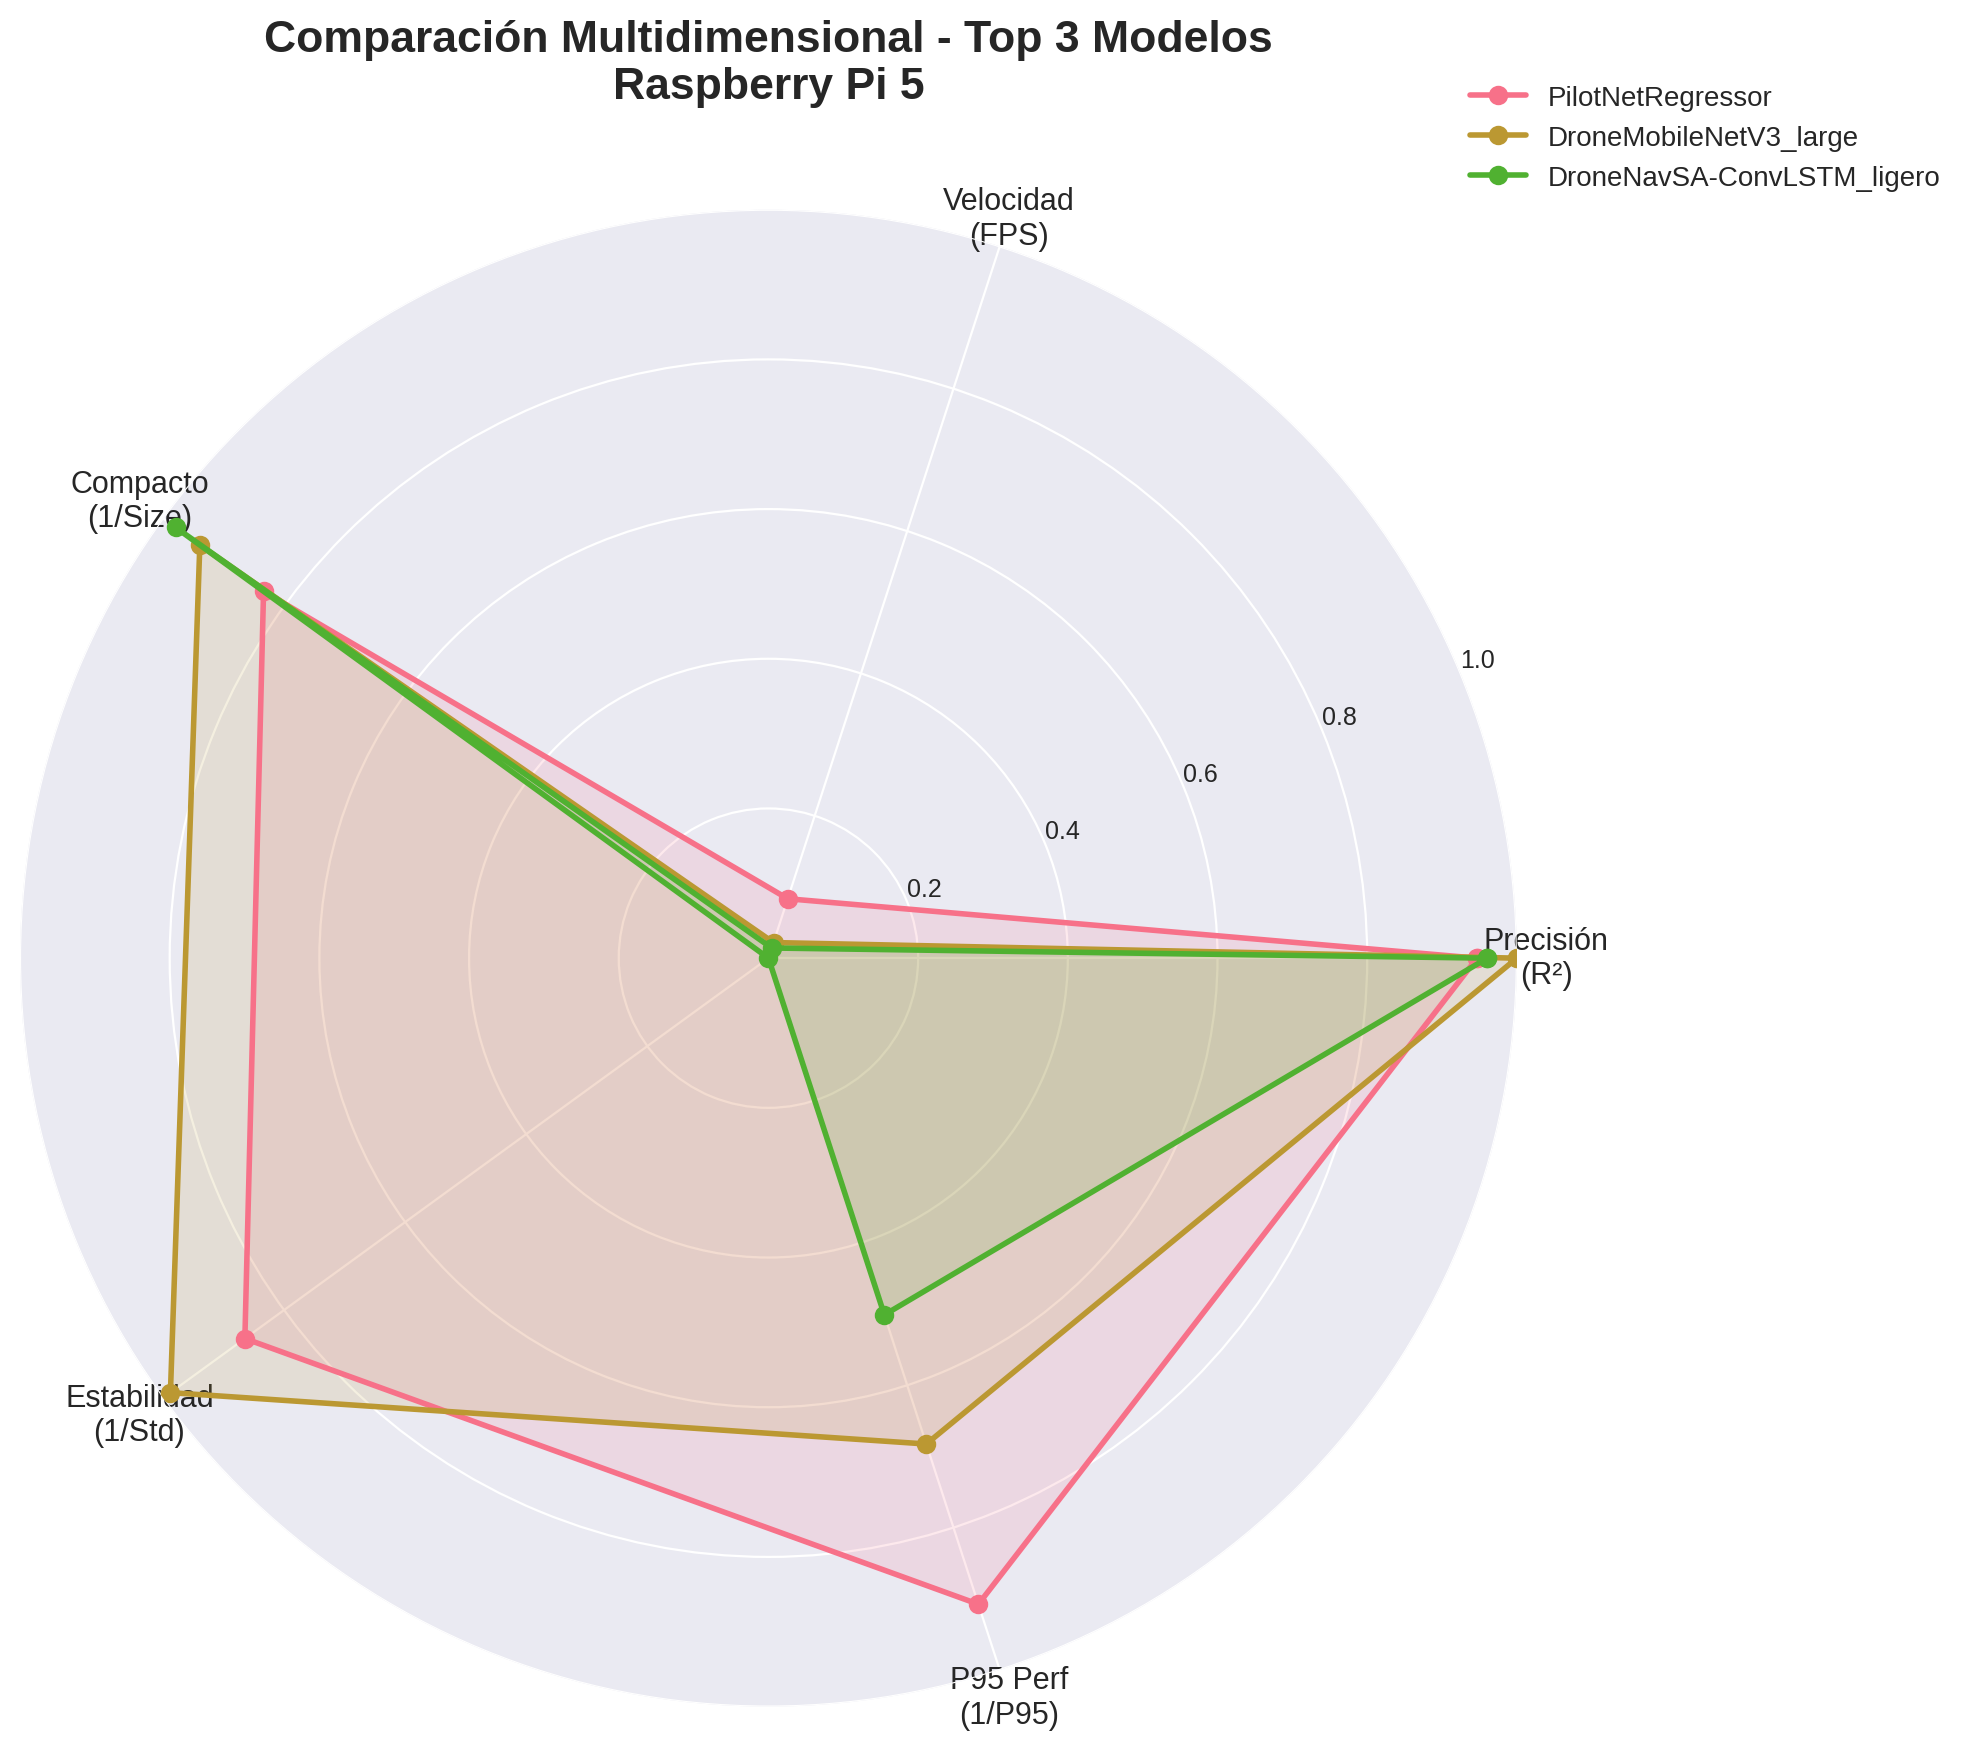

✅ Gráfica guardada: top3_radar_rpi5.png


In [23]:
# Radar chart comparando top 3 modelos
from math import pi

top_3 = df_efficiency.head(3)['Modelo'].tolist()

# Categorías para comparar
categories = ['Precisión\n(R²)', 'Velocidad\n(FPS)', 'Compacto\n(1/Size)', 
              'Estabilidad\n(1/Std)', 'P95 Perf\n(1/P95)']

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

for model_name in top_3:
    row = df_comparison[df_comparison['Modelo'] == model_name].iloc[0]
    
    # Normalizar valores [0, 1]
    r2_norm = (row['R²'] - df_comparison['R²'].min()) / (df_comparison['R²'].max() - df_comparison['R²'].min())
    fps_norm = (row['FPS'] - df_comparison['FPS'].min()) / (df_comparison['FPS'].max() - df_comparison['FPS'].min())
    size_norm = 1 - ((row['Tamaño (MB)'] - df_comparison['Tamaño (MB)'].min()) / (df_comparison['Tamaño (MB)'].max() - df_comparison['Tamaño (MB)'].min()))
    std_norm = 1 - ((row['Std (ms)'] - df_comparison['Std (ms)'].min()) / (df_comparison['Std (ms)'].max() - df_comparison['Std (ms)'].min()))
    p95_norm = 1 - ((row['P95 (ms)'] - df_comparison['P95 (ms)'].min()) / (df_comparison['P95 (ms)'].max() - df_comparison['P95 (ms)'].min()))
    
    values = [r2_norm, fps_norm, size_norm, std_norm, p95_norm]
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name)
    ax.fill(angles, values, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=11)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=9)
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)

plt.title(f'Comparación Multidimensional - Top 3 Modelos\n{HARDWARE_NAME}', 
          size=16, fontweight='bold', pad=40)
plt.tight_layout()
plt.savefig(f'top3_radar_{HARDWARE_TYPE}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Gráfica guardada: top3_radar_{HARDWARE_TYPE}.png")

## 🎓 18. Conclusiones y Recomendaciones

In [24]:
print("\n" + "="*80)
print("📋 CONCLUSIONES Y RECOMENDACIONES")
print("="*80 + "\n")

print(f"🎯 Hardware evaluado: {HARDWARE_NAME}")
print(f"🔧 Execution Provider: {EXECUTION_PROVIDER}")
print(f"📊 Total modelos: {len(all_results)}\n")

print("="*80)
print("🏆 RANKINGS")
print("="*80 + "\n")

print(f"MEJOR PRECISIÓN: {best_accuracy}")
print(f"  RMSE: {df_comparison[df_comparison['Modelo']==best_accuracy].iloc[0]['RMSE']:.6f}")
print(f"  R²: {df_comparison[df_comparison['Modelo']==best_accuracy].iloc[0]['R²']:.6f}\n")

print(f"MÁS RÁPIDO: {fastest_model}")
print(f"  Latencia: {df_comparison[df_comparison['Modelo']==fastest_model].iloc[0]['Latencia (ms)']:.2f} ms")
print(f"  FPS: {df_comparison[df_comparison['Modelo']==fastest_model].iloc[0]['FPS']:.2f}\n")

print(f"MÁS COMPACTO: {smallest_model}")
print(f"  Tamaño: {df_comparison[df_comparison['Modelo']==smallest_model].iloc[0]['Tamaño (MB)']:.2f} MB\n")

print(f"MEJOR BALANCE (Efficiency Score): {best_efficient}")
print(f"  Score: {df_efficiency.iloc[0]['Efficiency_Score']:.3f}")
print(f"  RMSE: {df_efficiency.iloc[0]['RMSE']:.6f}")
print(f"  Latencia: {df_efficiency.iloc[0]['Latencia (ms)']:.2f} ms")
print(f"  Tamaño: {df_efficiency.iloc[0]['Tamaño (MB)']:.2f} MB\n")

print("="*80)
print("💡 RECOMENDACIONES")
print("="*80 + "\n")

# Latencia aceptable para tiempo real (< 33ms = 30 FPS)
realtime_models = df_comparison[df_comparison['Latencia (ms)'] < 33.3]

if len(realtime_models) > 0:
    print(f"✅ {len(realtime_models)} modelos son capaces de inferencia en tiempo real (>30 FPS):")
    for idx, row in realtime_models.iterrows():
        print(f"   - {row['Modelo']}: {row['FPS']:.1f} FPS")
else:
    print("⚠️  Ningún modelo alcanza 30 FPS en este hardware")
    best_fps = df_comparison.sort_values('FPS', ascending=False).iloc[0]
    print(f"   El más rápido alcanza: {best_fps['FPS']:.1f} FPS ({best_fps['Modelo']})")

print(f"\n🔋 Para deployment en edge (limitado en recursos):")
print(f"   Recomendado: {best_efficient}")
print(f"   (Mejor balance entre precisión, velocidad y tamaño)")

print(f"\n🎯 Para máxima precisión (sin restricciones):")
print(f"   Recomendado: {best_accuracy}")

print("\n" + "="*80)
print("✅ Análisis completado. Revisa las gráficas y CSVs generados.")
print("="*80)


📋 CONCLUSIONES Y RECOMENDACIONES

🎯 Hardware evaluado: Raspberry Pi 5
🔧 Execution Provider: CPUExecutionProvider
📊 Total modelos: 10

🏆 RANKINGS

MEJOR PRECISIÓN: DroneMobileNetV3_large
  RMSE: 0.371707
  R²: 0.853392

MÁS RÁPIDO: ConvMLP
  Latencia: 2.81 ms
  FPS: 356.17

MÁS COMPACTO: ConvMLP
  Tamaño: 0.18 MB

MEJOR BALANCE (Efficiency Score): PilotNetRegressor
  Score: 0.910
  RMSE: 0.375368
  Latencia: 32.32 ms
  Tamaño: 53.36 MB

💡 RECOMENDACIONES

✅ 4 modelos son capaces de inferencia en tiempo real (>30 FPS):
   - PilotNetRegressor: 30.9 FPS
   - DroneMobileNetV3_small: 40.4 FPS
   - ConvLSTM: 35.1 FPS
   - ConvMLP: 356.2 FPS

🔋 Para deployment en edge (limitado en recursos):
   Recomendado: PilotNetRegressor
   (Mejor balance entre precisión, velocidad y tamaño)

🎯 Para máxima precisión (sin restricciones):
   Recomendado: DroneMobileNetV3_large

✅ Análisis completado. Revisa las gráficas y CSVs generados.


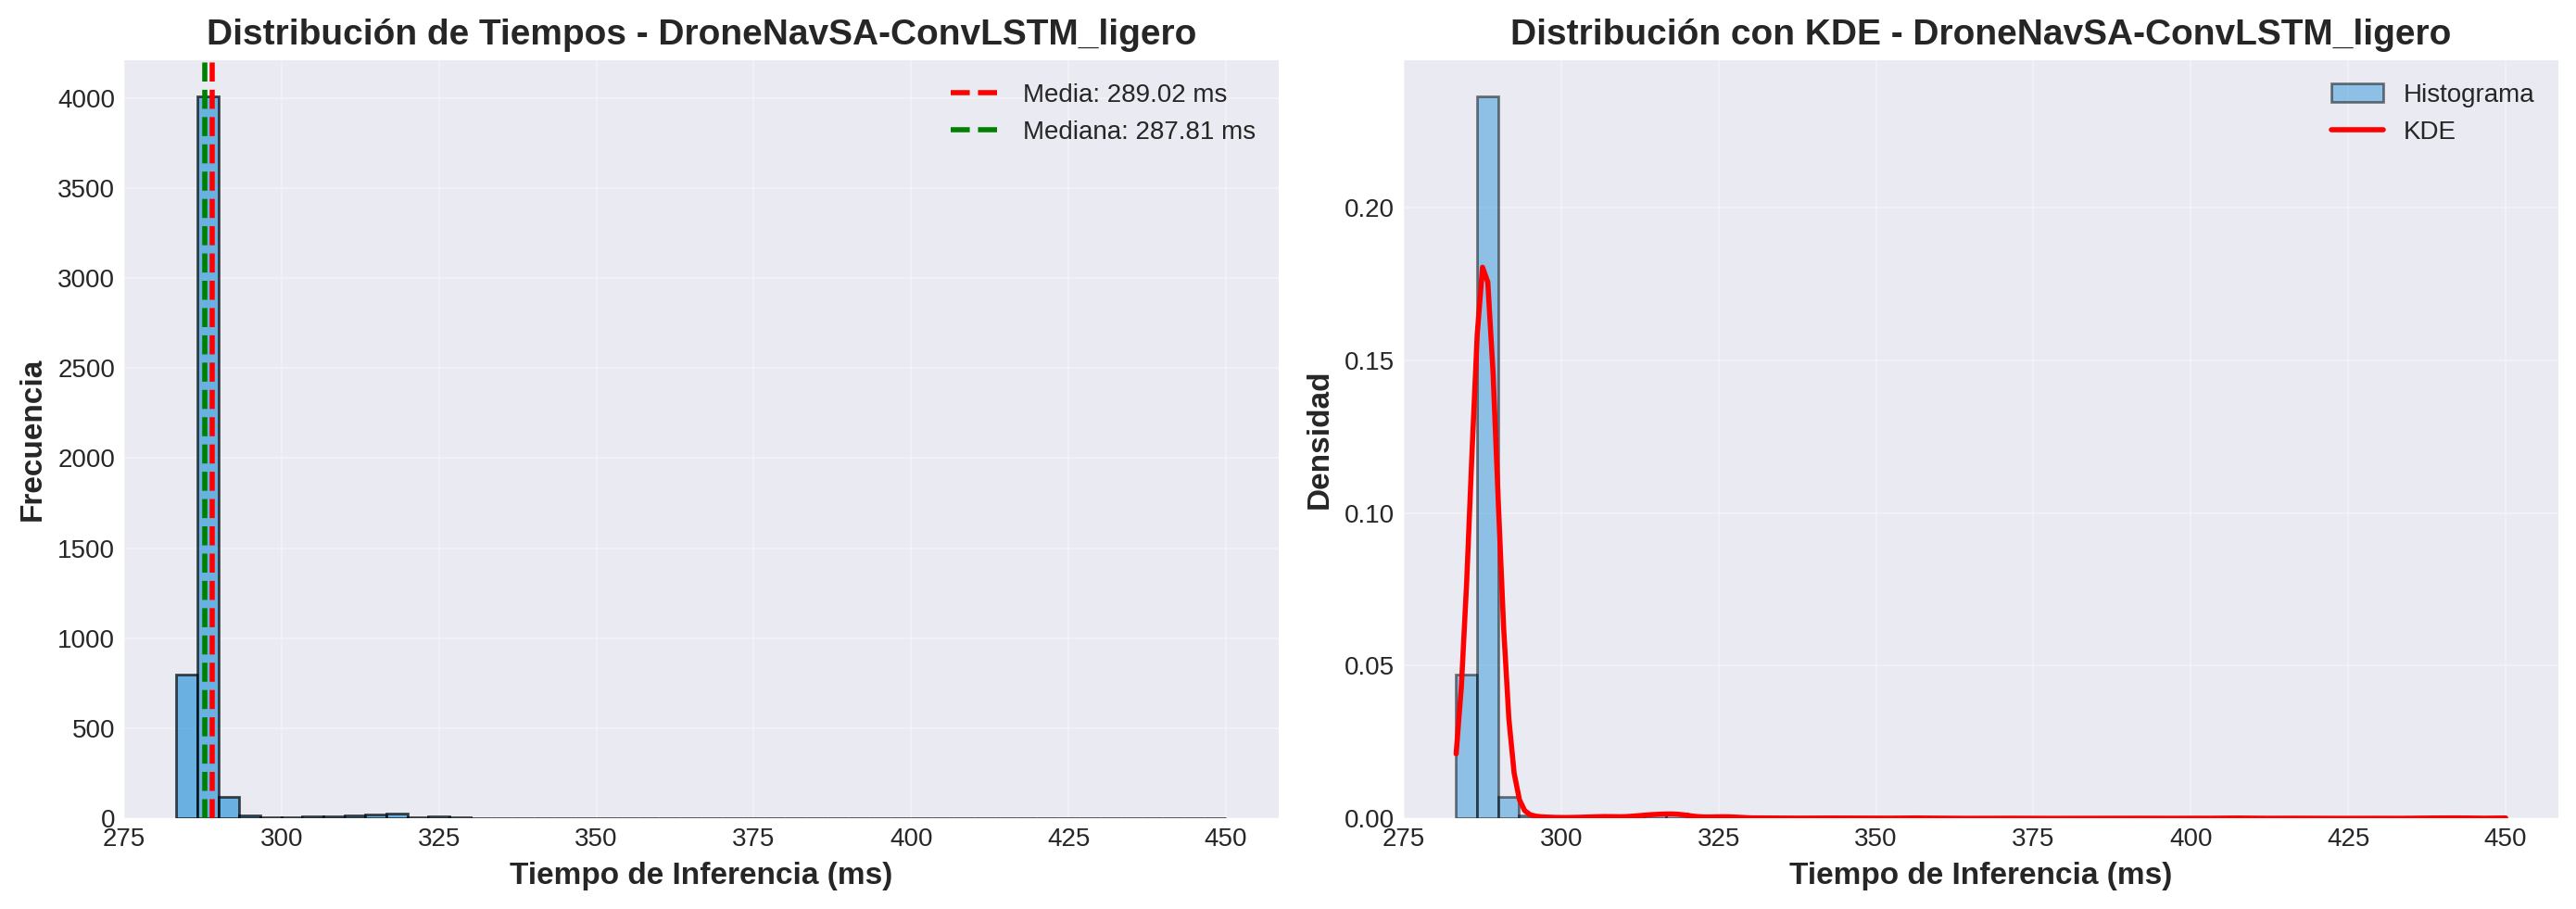


📊 Estadísticas de Tiempos - DroneNavSA-ConvLSTM_ligero
  Media: 289.02 ms
  Mediana: 287.81 ms
  Desv. Est.: 9.88 ms
  Min: 283.31 ms
  Max: 450.01 ms
  Percentil 95: 290.05 ms
  Percentil 99: 322.45 ms


In [25]:
# ============================================================================
# 📊 HISTOGRAMA DE TIEMPOS DE INFERENCIA
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma básico
axes[0].hist(inference_times, bins=50, color='#3498db', alpha=0.7, edgecolor='black')
axes[0].axvline(np.mean(inference_times), color='red', linestyle='--', linewidth=2, 
                label=f'Media: {np.mean(inference_times):.2f} ms')
axes[0].axvline(np.median(inference_times), color='green', linestyle='--', linewidth=2,
                label=f'Mediana: {np.median(inference_times):.2f} ms')
axes[0].set_xlabel('Tiempo de Inferencia (ms)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
axes[0].set_title(f'Distribución de Tiempos - {model_name}', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Histograma con KDE (distribución suavizada)
axes[1].hist(inference_times, bins=50, color='#3498db', alpha=0.5, edgecolor='black', 
             density=True, label='Histograma')
# KDE
from scipy import stats
kde = stats.gaussian_kde(inference_times)
x_range = np.linspace(min(inference_times), max(inference_times), 200)
axes[1].plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
axes[1].set_xlabel('Tiempo de Inferencia (ms)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Densidad', fontsize=12, fontweight='bold')
axes[1].set_title(f'Distribución con KDE - {model_name}', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'inference_times_histogram_{model_name}_{HARDWARE_TYPE}.png', dpi=300, bbox_inches='tight')
plt.show()

# Estadísticas adicionales
print(f"\n📊 Estadísticas de Tiempos - {model_name}")
print(f"  Media: {np.mean(inference_times):.2f} ms")
print(f"  Mediana: {np.median(inference_times):.2f} ms")
print(f"  Desv. Est.: {np.std(inference_times):.2f} ms")
print(f"  Min: {np.min(inference_times):.2f} ms")
print(f"  Max: {np.max(inference_times):.2f} ms")
print(f"  Percentil 95: {np.percentile(inference_times, 95):.2f} ms")
print(f"  Percentil 99: {np.percentile(inference_times, 99):.2f} ms")

---

## 🎯 Resumen de Archivos Generados

**📊 Datos:**
- `onnx_comparison_{hardware}.csv` - Comparación completa de todos los modelos
- `efficiency_scores_{hardware}.csv` - Ranking por efficiency score
- `onnx_evaluation_summary_{hardware}.txt` - Resumen textual

**📈 Visualizaciones:**
- `latency_vs_accuracy_{hardware}.png` - Trade-off latencia vs precisión
- `latency_distribution_{hardware}.png` - Distribución de latencias
- `model_sizes_{hardware}.png` - Comparación de tamaños
- `efficiency_score_{hardware}.png` - Ranking de efficiency
- `per_dimension_metrics_{hardware}.png` - Métricas por dimensión
- `top3_radar_{hardware}.png` - Radar chart top 3

---

## 📝 Notas para Deployment

### Raspberry Pi 5
- Usa CPUExecutionProvider optimizado para ARM
- Considera usar Hailo-8 NPU para aceleración adicional
- Batch size = 1 para latencia mínima

### Jetson Orin
- Usa CUDAExecutionProvider o TensorRT
- Considera cuantización INT8 para mayor velocidad
- Batch size puede ser > 1 si procesas múltiples frames

### Optimizaciones adicionales
- Quantization (FP16, INT8)
- Pruning
- Knowledge distillation
